In [1]:
! python -V

Python 3.9.7


In [6]:
! pip install transformers

     |████████████████████████████████| 3.1 MB 626 kB/s 
     |████████████████████████████████| 661 kB 9.8 MB/s 
     |████████████████████████████████| 762 kB 9.7 MB/s 
     |████████████████████████████████| 59 kB 4.7 MB/s 
     |████████████████████████████████| 62 kB 712 kB/s 
     |████████████████████████████████| 76 kB 3.7 MB/s 
     |████████████████████████████████| 3.3 MB 9.8 MB/s 
     |████████████████████████████████| 40 kB 4.5 MB/s 
     |████████████████████████████████| 895 kB 10.4 MB/s 
     |████████████████████████████████| 67 kB 4.4 MB/s 
     |████████████████████████████████| 138 kB 10.4 MB/s 
     |████████████████████████████████| 61 kB 5.1 MB/s 
     |████████████████████████████████| 97 kB 4.7 MB/s 
  Attempting uninstall: pyparsing
    Found existing installation: pyparsing 3.0.4
    Uninstalling pyparsing-3.0.4:
      Successfully uninstalled pyparsing-3.0.4


In [1]:
import random 
import time
import copy

import numpy as np
import pandas as pd
from tqdm import tqdm
import torch
import torch.nn as nn
from torch.cuda.amp import autocast, GradScaler

from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification
from transformers import BertTokenizer, BertModel, AdamW
from transformers import RobertaTokenizer, RobertaModel

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from torch.utils.data import Dataset, DataLoader

In [2]:
torch.cuda.is_available()

True

In [3]:
#CHECKPOINT = "sberbank-ai/sbert_large_nlu_ru"
MAX_LEN = 256
TRAIN_BATCH_SIZE = 16
VALID_BATCH_SIZE = 16
EPOCHS = 5
LEARNING_RATE = 2e-05
#tokenizer = AutoTokenizer.from_pretrained(CHECKPOINT)
CHECKPOINT = "roberta-base"
tokenizer = RobertaTokenizer.from_pretrained(CHECKPOINT)

In [4]:
%cd friends-classification/
!mkdir models
! ls

/home/andrew/ml/friends-classification
mkdir: cannot create directory ‘models’: File exists
example_eng_ru.csv
fb_model_translate_en_ru_2_friend_response_test.csv
fb_model_translate_en_ru_2_friend_response_train.csv
fb_model_translate_en_ru_2_friend_response_val.csv
fb_model_translate_en_ru_2_other_speaker_test.csv
fb_model_translate_en_ru_2_other_speaker_train.csv
fb_model_translate_en_ru_2_other_speaker_val.csv
fb_model_translate_ru_en_1_friend_response_test.csv
fb_model_translate_ru_en_1_friend_response_train.csv
fb_model_translate_ru_en_1_friend_response_val.csv
fb_model_translate_ru_en_1_other_speaker_test.csv
fb_model_translate_ru_en_1_other_speaker_train.csv
fb_model_translate_ru_en_1_other_speaker_val.csv
helsinki_model_translate_ru_en_1_friend_response_test.csv
helsinki_model_translate_ru_en_1_friend_response_train.csv
helsinki_model_translate_ru_en_1_friend_response_val.csv
helsinki_model_translate_ru_en_1_other_speaker_test.csv
helsinki_model_translate_ru_en_1_other_speaker_

In [5]:
df_train = pd.read_csv('train_data.csv').rename({'Category': 'label'}, axis=1)
df_train.other_speaker.fillna('', inplace=True)
df_val = pd.read_csv('val_data.csv')
df_val.other_speaker.fillna('', inplace=True)
df_test = pd.read_csv('test.csv')
df_test.other_speaker.fillna('', inplace=True)

# Encoding target variable
names_to_cats = LabelEncoder()
df_train['label_code'] = names_to_cats.fit_transform(df_train.label)
df_val['label_code'] = names_to_cats.transform(df_val.label)
df_fb_train = pd.read_csv('train_data_rus_fb_model.csv')
df_full = pd.concat([df_train, df_val])
print(df_train["label"].value_counts()/df_train.shape[0])
print()
print(df_val["label"].value_counts()/df_val.shape[0])

РОСС       0.176569
РЕЙЧЕЛ     0.176089
ЧЕНДЛЕР    0.170568
ДЖОУИ      0.166287
МОНИКА     0.160525
ФИБИ       0.149962
Name: label, dtype: float64

РОСС       0.176746
РЕЙЧЕЛ     0.176026
ЧЕНДЛЕР    0.170626
ДЖОУИ      0.166307
МОНИКА     0.160547
ФИБИ       0.149748
Name: label, dtype: float64


In [5]:
df_train = pd.read_csv('train_data_eng_fb_model.csv')
df_train.other_speaker.fillna('', inplace=True)
df_val = pd.read_csv('val_data_eng_fb_model.csv')
df_val.other_speaker.fillna('', inplace=True)
df_test = pd.read_csv('test_data_eng_fb_model.csv')
df_test.other_speaker.fillna('', inplace=True)

df_train2 = pd.read_csv('train_data_eng_helsinki_model.csv')
df_train2.other_speaker.fillna('', inplace=True)
df_val2 = pd.read_csv('val_data_eng_helsinki_model.csv')
df_val2.other_speaker.fillna('', inplace=True)
df_test2 = pd.read_csv('test_data_eng_helsinki_model.csv')
df_test2.other_speaker.fillna('', inplace=True)

df_train3 = pd.read_csv('train_data_eng_google_model.csv')
df_train3.other_speaker.fillna('', inplace=True)
df_val3 = pd.read_csv('val_data_eng_google_model.csv')
df_val3.other_speaker.fillna('', inplace=True)
df_test3 = pd.read_csv('test_data_eng_google_model.csv')
df_test3.other_speaker.fillna('', inplace=True)

# Encoding target variable
names_to_cats = LabelEncoder()
df_train['label_code'] = names_to_cats.fit_transform(df_train.label)
df_val['label_code'] = names_to_cats.transform(df_val.label)
df_fb_train = pd.read_csv('train_data_rus_fb_model.csv')
df_full = pd.concat([df_train, df_val])
print(df_train["label"].value_counts()/df_train.shape[0])
print()
print(df_val["label"].value_counts()/df_val.shape[0])

РОСС       0.176569
РЕЙЧЕЛ     0.176089
ЧЕНДЛЕР    0.170568
ДЖОУИ      0.166287
МОНИКА     0.160525
ФИБИ       0.149962
Name: label, dtype: float64

РОСС       0.176746
РЕЙЧЕЛ     0.176026
ЧЕНДЛЕР    0.170626
ДЖОУИ      0.166307
МОНИКА     0.160547
ФИБИ       0.149748
Name: label, dtype: float64


In [6]:
df_train_2X = pd.concat([df_train, df_train2])
df_train_3X = pd.concat([df_train, df_train2, df_train3])
df_val_3X = pd.concat([df_val, df_val2, df_val3])

In [7]:
print(df_train.shape, df_val.shape, df_test.shape)
df_val

(24993, 5) (2778, 5) (3086, 3)


,Id,other_speaker,friend_response,label,label_code
0,0,"Good, and we don't eat at all?","Come on, it's time to be serious, to fight the...",МОНИКА,1
1,1,"All right, all right, listen, I know I'm Mr. I...","Good, here it is! Get off it!",РОСС,3
2,2,"Yeah. You know, I have all these feelings, and...","Well, I saw a pretty big pigeon.",ДЖОУИ,0
3,3,"My God! Just a few minutes ago, and now I am.","Wait, you can't give birth here! That is, I di...",МОНИКА,1
4,4,"Not as he is, just not as he is.","Look, this is an artist formerly known as Chan...",РОСС,3
...,...,...,...,...,...
2773,2773,What's going on tonight?,This is our first official date. Our first date.,РЕЙЧЕЛ,2
2774,2774,"Hey, aren't you dressed up?","Yes, and this time you better make sure that h...",РЕЙЧЕЛ,2
2775,2775,You were not there!,"No, but it's, you know, just a funny picture, ...",РОСС,3
2776,2776,You are talking on the phone!,"That was the fire part, we had a fire!",РЕЙЧЕЛ,2


In [8]:
class FriendsDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length=512, padding='max_length', 
                 with_labels=True):

        self.dataframe = dataframe  # pandas dataframe
        #Initialize the tokenizer
        self.tokenizer = tokenizer  
        self.padding = padding
        self.max_length = max_length
        
        self.with_labels = with_labels 
        if 'label' not in self.dataframe.columns:
          self.with_labels = False

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):

        # Selecting sentence1 and sentence2 at the specified index in the data frame
        sent1 = self.dataframe.other_speaker.iloc[index]
        sent2 = self.dataframe.friend_response.iloc[index]

        # Tokenize the pair of sentences to get token ids, attention masks and token type ids
        encoded_pair = self.tokenizer(sent1, sent2, 
                                      padding=self.padding,  # Pad to max_length
                                      truncation=True,  # Truncate to max_length
                                      max_length=self.max_length,  
                                      return_tensors='pt')  # Return torch.Tensor objects
        
        token_ids = encoded_pair['input_ids'].squeeze(0)  # tensor of token ids
        attn_masks = encoded_pair['attention_mask'].squeeze(0)  # binary tensor with "0" for padded values and "1" for the other values
        #token_type_ids = encoded_pair['token_type_ids'].squeeze(0)  # binary tensor with "0" for the 1st sentence tokens & "1" for the 2nd sentence tokens

        if self.with_labels:  # True if the dataset has labels
            label = self.dataframe.label_code.iloc[index]
            return token_ids, attn_masks,  label  
        else:
            return token_ids, attn_masks#, token_type_ids

<AxesSubplot:>

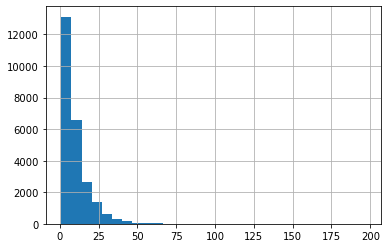

In [10]:
seq_len = [len(i.split()) for i in df_train.other_speaker.fillna('')]

pd.Series(seq_len).hist(bins = 30)

30857 number of all dialogs in train, validation and test


13         1
16         2
17         5
18        12
19        24
       ...  
266    29799
267    29821
268    29842
269    29851
270    29872
Name: seq_len, Length: 256, dtype: int64

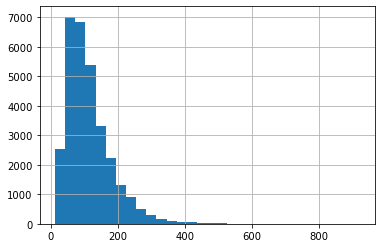

In [11]:
dfs_all = pd.concat([df_train, df_val, df_test])
dfs_all['seq_len'] = dfs_all.apply(lambda row: 
                                   len(row['other_speaker'] + row['friend_response']), axis=1)
print(len(dfs_all), "number of all dialogs in train, validation and test")
[len(i.split()) for i in dfs_all.other_speaker]
dfs_all['seq_len'].hist(bins = 30)
dfs_all['seq_len'].value_counts().sort_index(ascending=True).cumsum().head(256)

In [9]:
class SentencePairClassifier(nn.Module):

    def __init__(self, model=CHECKPOINT, freeze_model=True):
        super(SentencePairClassifier, self).__init__()
        #  Instantiating BERT-based model object
        # self.pretrained_layer = AutoModel.from_pretrained(CHECKPOINT)
        #self.pretrained_layer = BertModel.from_pretrained(CHECKPOINT)
        self.pretrained_layer = RobertaModel.from_pretrained(CHECKPOINT)

        hidden_size = self.pretrained_layer.config.hidden_size

        # Freeze model layers and only train the classification layer weights
        if freeze_model:
            for p in self.pretrained_layer.parameters():
                p.requires_grad = False
            print('All parameters frozen')
        # Classification layer
        self.cls_layer = nn.Linear(hidden_size, 6)

        self.dropout = nn.Dropout(p=0.1)

    @autocast()  # run in mixed precision
    def forward(self, input_ids, attn_masks):
        '''
        Inputs:
            -input_ids : Tensor  containing token ids
            -attn_masks : Tensor containing attention masks to be used to focus on non-padded values
            -token_type_ids : Tensor containing token type ids to be used to identify sentence1 and sentence2
        '''

        # Feeding the inputs to the BERT-based model to obtain contextualized representations
        output = self.pretrained_layer(input_ids, attn_masks)

        # Feeding to the classifier layer the last layer hidden-state of the [CLS] token further processed by a
        # Linear Layer and a Tanh activation. The Linear layer weights were trained from the sentence order prediction (ALBERT) or next sentence prediction (BERT)
        # objective during pre-training.
        logits = self.cls_layer(self.dropout(output.pooler_output))

        return logits

In [10]:
def set_seed(seed):
    """ Set all seeds to make results reproducible """
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)
    #os.environ['PYTHONHASHSEED'] = str(seed)
    

def evaluate_loss(net, device, criterion, dataloader):
    net.eval()
    n_correct = 0
    mean_loss = 0
    count = 0

    with torch.no_grad():
        for it, (seq, attn_masks, labels) in enumerate(tqdm(dataloader)):
            seq, attn_masks, labels = \
                seq.to(device), attn_masks.to(device), labels.to(device)
            logits = net(seq, attn_masks)
            mean_loss += criterion(logits.squeeze(-1), labels).item()
            count += 1
            max_logits, argmax_idx = torch.max(logits.data, dim=1)
            n_correct += calcuate_accu(argmax_idx, labels)
    del logits
    return mean_loss / count, n_correct / len(dataloader.dataset)
  
# Function to calcuate the accuracy of the model
def calcuate_accu(big_idx, targets):
    n_correct = (big_idx==targets).sum().item()
    return n_correct

In [11]:
def train_bert(net, criterion, opti, lr, lr_scheduler, train_loader, val_loader, epochs, iters_to_accumulate):

    best_loss = np.Inf
    best_acc = 0
    best_ep = 1
    n_iterations = len(train_loader)
    batch_size = train_loader.batch_size
    print_every = 1000 // batch_size  # print the training loss this many times per epoch
    print_eval_iters = 10000 // batch_size
    scaler = GradScaler()

    for ep in range(epochs):
        net.train()
        curr_loss = 0.0
        curr_n_correct = 0.
        trailing_loss = 0.
        trailing_n_correct = 0.
        curr_n_tr_examples = 0
        trainling_n_tr_examples = 0

        for it, (seq, attn_masks, labels) in enumerate(tqdm(train_loader)):
            # Converting to cuda tensors
            seq, attn_masks,labels = \
                seq.to(device), attn_masks.to(device), labels.to(device)
  
            # Enables autocasting for the forward pass (model + loss)
            with autocast():
                # Obtaining the logits from the model
                pooled = net(seq, attn_masks)

                # Computing loss
                loss = criterion(pooled.squeeze(-1), labels)
                #print(loss, type(loss))
                loss = loss / iters_to_accumulate  # Normalize the loss because it is averaged
                # Computing accuracy
                #print(pooled.squeeze(-1), labels)
                curr_loss += loss.item() 
                big_val, big_idx = torch.max(pooled.data, dim=1)
                n_correct = calcuate_accu(big_idx, labels)
                curr_n_correct += n_correct

            trailing_loss += loss.item() 
            trailing_n_correct += n_correct
            curr_n_tr_examples += labels.size(0)
            trainling_n_tr_examples += labels.size(0)

            # Backpropagating the gradients
            # Scales loss.  Calls backward() on scaled loss to create scaled gradients.
            scaler.scale(loss).backward()

            if (it + 1) % iters_to_accumulate == 0:
                # Optimization step
                # scaler.step() first unscales the gradients of the optimizer's assigned params.
                # If these gradients do not contain infs or NaNs, opti.step() is then called,
                # otherwise, opti.step() is skipped.
                scaler.step(opti)
                # Updates the scale for next iteration.
                scaler.update()
                # Adjust the learning rate based on the number of iterations.
                lr_scheduler.step()
                # Clear gradients
                opti.zero_grad()

            if (it + 1) % print_every == 0:  # Print training loss information
                print()
                print("Batch {}/{} of epoch {} complete. Loss per last {} samples:: {} "
                      .format(it+1, n_iterations, ep+1, curr_n_tr_examples, curr_loss / print_every))
                accu_step = (curr_n_correct*100) / curr_n_tr_examples 
                #print(f"Training Loss per 5000 steps: {loss_step}")
                print(f"Training Accuracy per last {curr_n_tr_examples} samples: {accu_step}")
                curr_loss = 0.0
                curr_n_tr_examples = 0
                curr_n_correct = 0


            if (it + 1) % print_eval_iters == 0 or it ==  n_iterations - 1:
                del pooled, loss
                print("Epoch {}, batch {} complete! Training Loss : {}"
                .format(ep+1, it+1, trailing_loss / (it+1)))
                print("Epoch {}, batch {} complete! Training Accuracy : {}"
                .format(ep+1, it+1, trailing_n_correct / trainling_n_tr_examples))
                val_loss, val_accuracy = evaluate_loss(net, device, criterion, val_loader)  # Compute validation loss
                #print()
                print("Epoch {}, batch {} complete! Validation Loss : {}".format(ep+1, it+1, val_loss))
                print("Epoch {}, batch {} complete! Validation Accuracy : {}".format(ep+1, it+1,val_accuracy))
                net.train()
                #if val_loss < best_loss:
                if val_accuracy > best_acc:
                    print("Validation loss changed from {} to {}".format(best_loss, val_loss))
                    print("Best validation accuracy improved from {} to {}".format(best_acc, val_accuracy))
                    print()
                    #net_copy = copy.deepcopy(net)  # save a copy of the model
                    best_loss = val_loss
                    best_acc = val_accuracy
                    best_ep = ep + 1
                    # Saving the model
                    path_to_model='models/{}_lr_{}_val_acc_{}_ep_{}.pt'.format(time.ctime(), lr, round(best_acc, 4), best_ep)
                    torch.save(net.state_dict(), path_to_model)
                    print("The model has been saved in {}".format(path_to_model))

    torch.cuda.empty_cache()

In [12]:
from transformers import get_linear_schedule_with_warmup
from transformers import get_constant_schedule
#  Set all seeds to make reproducible results
set_seed(1)

# Creating instances of training and validation set
print("Reading training data...")
train_set = FriendsDataset(dataframe=df_train_3X, tokenizer=tokenizer, max_length=MAX_LEN)
#train_set = FriendsDataset(dataframe=df_full, tokenizer=tokenizer, max_length=MAX_LEN)

print("Reading validation data...")
val_set = FriendsDataset(dataframe=df_val_3X, tokenizer=tokenizer, max_length=MAX_LEN)
# Creating instances of training and validation dataloaders
train_loader = DataLoader(train_set, batch_size=TRAIN_BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_set, batch_size=VALID_BATCH_SIZE, shuffle=False, num_workers=2)


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = SentencePairClassifier(model=CHECKPOINT, freeze_model=False)
print(device)

if torch.cuda.device_count() > 1:  # if multiple GPUs
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    net = nn.DataParallel(net)

net.to(device)

criterion = nn.CrossEntropyLoss()
opti = AdamW(net.parameters(), lr=LEARNING_RATE)#, weight_decay=1e-2)
num_warmup_steps = 0 # The number of steps for the warmup phase.
iters_to_accumulate = 2
num_training_steps = EPOCHS * len(train_loader)  # The total number of training steps
t_total = (len(train_loader) // iters_to_accumulate) * EPOCHS  # Necessary to take into account Gradient accumulation
#lr_scheduler = get_linear_schedule_with_warmup(optimizer=opti, num_warmup_steps=num_warmup_steps, num_training_steps=t_total)
lr_scheduler = get_constant_schedule(optimizer=opti)


Reading training data...
Reading validation data...


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


cuda:0


In [13]:
train_bert(net, criterion, opti, LEARNING_RATE, lr_scheduler, train_loader, val_loader, EPOCHS, iters_to_accumulate)

  1%|▏         | 62/4687 [00:43<53:08,  1.45it/s]


Batch 62/4687 of epoch 1 complete. Loss per last 992 samples:: 0.8985477570564516 
Training Accuracy per last 992 samples: 17.741935483870968


  3%|▎         | 124/4687 [01:26<53:02,  1.43it/s]


Batch 124/4687 of epoch 1 complete. Loss per last 992 samples:: 0.8961629559916835 
Training Accuracy per last 992 samples: 18.548387096774192


  4%|▍         | 186/4687 [02:08<53:55,  1.39it/s]


Batch 186/4687 of epoch 1 complete. Loss per last 992 samples:: 0.8963819934475806 
Training Accuracy per last 992 samples: 18.245967741935484


  5%|▌         | 248/4687 [02:52<51:48,  1.43it/s]


Batch 248/4687 of epoch 1 complete. Loss per last 992 samples:: 0.8948826943674395 
Training Accuracy per last 992 samples: 18.850806451612904


  7%|▋         | 310/4687 [03:35<51:08,  1.43it/s]


Batch 310/4687 of epoch 1 complete. Loss per last 992 samples:: 0.8943397768082157 
Training Accuracy per last 992 samples: 17.54032258064516


  8%|▊         | 372/4687 [04:18<51:16,  1.40it/s]


Batch 372/4687 of epoch 1 complete. Loss per last 992 samples:: 0.896913097750756 
Training Accuracy per last 992 samples: 16.633064516129032


  9%|▉         | 434/4687 [05:02<50:20,  1.41it/s]


Batch 434/4687 of epoch 1 complete. Loss per last 992 samples:: 0.8975884222215221 
Training Accuracy per last 992 samples: 16.431451612903224


 11%|█         | 496/4687 [05:43<44:24,  1.57it/s]


Batch 496/4687 of epoch 1 complete. Loss per last 992 samples:: 0.894837410219254 
Training Accuracy per last 992 samples: 19.254032258064516


 12%|█▏        | 558/4687 [06:22<43:53,  1.57it/s]


Batch 558/4687 of epoch 1 complete. Loss per last 992 samples:: 0.8945489698840726 
Training Accuracy per last 992 samples: 18.044354838709676


 13%|█▎        | 620/4687 [07:02<42:57,  1.58it/s]


Batch 620/4687 of epoch 1 complete. Loss per last 992 samples:: 0.8943427301222279 
Training Accuracy per last 992 samples: 16.733870967741936


 13%|█▎        | 624/4687 [07:04<43:14,  1.57it/s]

Epoch 1, batch 625 complete! Training Loss : 0.895867919921875
Epoch 1, batch 625 complete! Training Accuracy : 0.178


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

Epoch 1, batch 625 complete! Validation Loss : 1.7919097138915547
Epoch 1, batch 625 complete! Validation Accuracy : 0.16162706983441325
Validation loss changed from inf to 1.7919097138915547
Best validation accuracy improved from 0 to 0.16162706983441325



 13%|█▎        | 625/4687 [09:05<41:35:03, 36.85s/it]

The model has been saved in models/Wed Nov 17 13:21:05 2021_lr_2e-05_val_acc_0.1616_ep_1.pt


 15%|█▍        | 682/4687 [09:42<42:20,  1.58it/s]


Batch 682/4687 of epoch 1 complete. Loss per last 992 samples:: 0.8991945328251008 
Training Accuracy per last 992 samples: 16.028225806451612


 16%|█▌        | 744/4687 [10:21<41:45,  1.57it/s]


Batch 744/4687 of epoch 1 complete. Loss per last 992 samples:: 0.897123767483619 
Training Accuracy per last 992 samples: 17.137096774193548


 17%|█▋        | 806/4687 [11:01<41:11,  1.57it/s]


Batch 806/4687 of epoch 1 complete. Loss per last 992 samples:: 0.893797843686996 
Training Accuracy per last 992 samples: 20.866935483870968


 19%|█▊        | 868/4687 [11:40<40:21,  1.58it/s]


Batch 868/4687 of epoch 1 complete. Loss per last 992 samples:: 0.8967043968939012 
Training Accuracy per last 992 samples: 18.75


 20%|█▉        | 930/4687 [12:20<39:42,  1.58it/s]


Batch 930/4687 of epoch 1 complete. Loss per last 992 samples:: 0.8904694587953629 
Training Accuracy per last 992 samples: 20.967741935483872


 21%|██        | 992/4687 [12:59<39:29,  1.56it/s]


Batch 992/4687 of epoch 1 complete. Loss per last 992 samples:: 0.8840856244487147 
Training Accuracy per last 992 samples: 21.975806451612904


 22%|██▏       | 1054/4687 [13:39<38:27,  1.57it/s]


Batch 1054/4687 of epoch 1 complete. Loss per last 992 samples:: 0.8899883147208921 
Training Accuracy per last 992 samples: 21.27016129032258


 24%|██▍       | 1116/4687 [14:18<37:45,  1.58it/s]


Batch 1116/4687 of epoch 1 complete. Loss per last 992 samples:: 0.8860988001669606 
Training Accuracy per last 992 samples: 22.883064516129032


 25%|██▌       | 1178/4687 [14:58<38:49,  1.51it/s]


Batch 1178/4687 of epoch 1 complete. Loss per last 992 samples:: 0.8837944769090221 
Training Accuracy per last 992 samples: 22.379032258064516


 26%|██▋       | 1240/4687 [15:37<36:33,  1.57it/s]


Batch 1240/4687 of epoch 1 complete. Loss per last 992 samples:: 0.8806686401367188 
Training Accuracy per last 992 samples: 22.278225806451612


 27%|██▋       | 1249/4687 [15:43<36:25,  1.57it/s]

Epoch 1, batch 1250 complete! Training Loss : 0.8930215454101562
Epoch 1, batch 1250 complete! Training Accuracy : 0.19125


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

Epoch 1, batch 1250 complete! Validation Loss : 1.7646072006957774
Epoch 1, batch 1250 complete! Validation Accuracy : 0.21754259659227262
Validation loss changed from 1.7919097138915547 to 1.7646072006957774
Best validation accuracy improved from 0.16162706983441325 to 0.21754259659227262



 27%|██▋       | 1250/4687 [17:44<35:16:01, 36.94s/it]

The model has been saved in models/Wed Nov 17 13:29:44 2021_lr_2e-05_val_acc_0.2175_ep_1.pt


 28%|██▊       | 1302/4687 [18:17<35:51,  1.57it/s]


Batch 1302/4687 of epoch 1 complete. Loss per last 992 samples:: 0.8841976042716734 
Training Accuracy per last 992 samples: 20.967741935483872


 29%|██▉       | 1364/4687 [18:57<35:14,  1.57it/s]


Batch 1364/4687 of epoch 1 complete. Loss per last 992 samples:: 0.867322983280305 
Training Accuracy per last 992 samples: 26.713709677419356


 30%|███       | 1426/4687 [19:36<34:35,  1.57it/s]


Batch 1426/4687 of epoch 1 complete. Loss per last 992 samples:: 0.875853753858997 
Training Accuracy per last 992 samples: 23.991935483870968


 32%|███▏      | 1488/4687 [20:16<35:13,  1.51it/s]


Batch 1488/4687 of epoch 1 complete. Loss per last 992 samples:: 0.8673132619550151 
Training Accuracy per last 992 samples: 23.588709677419356


 33%|███▎      | 1550/4687 [20:55<33:19,  1.57it/s]


Batch 1550/4687 of epoch 1 complete. Loss per last 992 samples:: 0.8685777110438193 
Training Accuracy per last 992 samples: 24.798387096774192


 34%|███▍      | 1612/4687 [21:35<32:31,  1.58it/s]


Batch 1612/4687 of epoch 1 complete. Loss per last 992 samples:: 0.8692088588591544 
Training Accuracy per last 992 samples: 25.0


 36%|███▌      | 1674/4687 [22:14<31:52,  1.58it/s]


Batch 1674/4687 of epoch 1 complete. Loss per last 992 samples:: 0.8592952605216734 
Training Accuracy per last 992 samples: 29.233870967741936


 37%|███▋      | 1736/4687 [22:53<31:15,  1.57it/s]


Batch 1736/4687 of epoch 1 complete. Loss per last 992 samples:: 0.8662808325982863 
Training Accuracy per last 992 samples: 25.302419354838708


 38%|███▊      | 1798/4687 [23:33<30:37,  1.57it/s]


Batch 1798/4687 of epoch 1 complete. Loss per last 992 samples:: 0.8555279393349925 
Training Accuracy per last 992 samples: 26.31048387096774


 40%|███▉      | 1860/4687 [24:12<29:55,  1.57it/s]


Batch 1860/4687 of epoch 1 complete. Loss per last 992 samples:: 0.8449366169591104 
Training Accuracy per last 992 samples: 28.72983870967742


 40%|███▉      | 1874/4687 [24:21<29:45,  1.58it/s]

Epoch 1, batch 1875 complete! Training Loss : 0.883684130859375
Epoch 1, batch 1875 complete! Training Accuracy : 0.21283333333333335


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

Epoch 1, batch 1875 complete! Validation Loss : 1.7105251319577734
Epoch 1, batch 1875 complete! Validation Accuracy : 0.27513798896088315
Validation loss changed from 1.7646072006957774 to 1.7105251319577734
Best validation accuracy improved from 0.21754259659227262 to 0.27513798896088315



 40%|████      | 1875/4687 [26:20<28:14:05, 36.15s/it]

The model has been saved in models/Wed Nov 17 13:38:20 2021_lr_2e-05_val_acc_0.2751_ep_1.pt


 41%|████      | 1922/4687 [26:50<30:37,  1.50it/s]


Batch 1922/4687 of epoch 1 complete. Loss per last 992 samples:: 0.8483687985327936 
Training Accuracy per last 992 samples: 27.318548387096776


 42%|████▏     | 1984/4687 [27:30<28:32,  1.58it/s]


Batch 1984/4687 of epoch 1 complete. Loss per last 992 samples:: 0.8487681727255544 
Training Accuracy per last 992 samples: 28.830645161290324


 44%|████▎     | 2046/4687 [28:09<27:51,  1.58it/s]


Batch 2046/4687 of epoch 1 complete. Loss per last 992 samples:: 0.8553660608107044 
Training Accuracy per last 992 samples: 28.326612903225808


 45%|████▍     | 2108/4687 [28:49<27:09,  1.58it/s]


Batch 2108/4687 of epoch 1 complete. Loss per last 992 samples:: 0.8372029335268082 
Training Accuracy per last 992 samples: 30.846774193548388


 46%|████▋     | 2170/4687 [29:28<26:32,  1.58it/s]


Batch 2170/4687 of epoch 1 complete. Loss per last 992 samples:: 0.8423856304537866 
Training Accuracy per last 992 samples: 30.342741935483872


 48%|████▊     | 2232/4687 [30:07<25:57,  1.58it/s]


Batch 2232/4687 of epoch 1 complete. Loss per last 992 samples:: 0.8412671242990801 
Training Accuracy per last 992 samples: 30.342741935483872


 49%|████▉     | 2294/4687 [30:46<25:13,  1.58it/s]


Batch 2294/4687 of epoch 1 complete. Loss per last 992 samples:: 0.8451488248763546 
Training Accuracy per last 992 samples: 29.33467741935484


 50%|█████     | 2356/4687 [31:25<24:32,  1.58it/s]


Batch 2356/4687 of epoch 1 complete. Loss per last 992 samples:: 0.8232191147342804 
Training Accuracy per last 992 samples: 31.955645161290324


 52%|█████▏    | 2418/4687 [32:05<24:03,  1.57it/s]


Batch 2418/4687 of epoch 1 complete. Loss per last 992 samples:: 0.8417539904194493 
Training Accuracy per last 992 samples: 29.737903225806452


 53%|█████▎    | 2480/4687 [32:44<23:20,  1.58it/s]


Batch 2480/4687 of epoch 1 complete. Loss per last 992 samples:: 0.8304824213827809 
Training Accuracy per last 992 samples: 31.048387096774192


 53%|█████▎    | 2499/4687 [32:56<23:03,  1.58it/s]

Epoch 1, batch 2500 complete! Training Loss : 0.8729039962768554
Epoch 1, batch 2500 complete! Training Accuracy : 0.234425


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

Epoch 1, batch 2500 complete! Validation Loss : 1.6853050773752398
Epoch 1, batch 2500 complete! Validation Accuracy : 0.28509719222462204
Validation loss changed from 1.7105251319577734 to 1.6853050773752398
Best validation accuracy improved from 0.27513798896088315 to 0.28509719222462204



 53%|█████▎    | 2500/4687 [34:55<21:54:26, 36.06s/it]

The model has been saved in models/Wed Nov 17 13:46:55 2021_lr_2e-05_val_acc_0.2851_ep_1.pt


 54%|█████▍    | 2542/4687 [35:22<22:45,  1.57it/s]


Batch 2542/4687 of epoch 1 complete. Loss per last 992 samples:: 0.8186922688638011 
Training Accuracy per last 992 samples: 31.149193548387096


 56%|█████▌    | 2604/4687 [36:01<22:01,  1.58it/s]


Batch 2604/4687 of epoch 1 complete. Loss per last 992 samples:: 0.8224147365939233 
Training Accuracy per last 992 samples: 31.552419354838708


 57%|█████▋    | 2666/4687 [36:40<21:24,  1.57it/s]


Batch 2666/4687 of epoch 1 complete. Loss per last 992 samples:: 0.821492564293646 
Training Accuracy per last 992 samples: 31.149193548387096


 58%|█████▊    | 2728/4687 [37:20<20:42,  1.58it/s]


Batch 2728/4687 of epoch 1 complete. Loss per last 992 samples:: 0.8353887373401273 
Training Accuracy per last 992 samples: 30.846774193548388


 60%|█████▉    | 2790/4687 [37:59<20:05,  1.57it/s]Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.



Batch 2790/4687 of epoch 1 complete. Loss per last 992 samples:: 0.8256476925265405 
Training Accuracy per last 992 samples: 30.241935483870968


 61%|██████    | 2852/4687 [38:38<19:29,  1.57it/s]


Batch 2852/4687 of epoch 1 complete. Loss per last 992 samples:: 0.8303430618778351 
Training Accuracy per last 992 samples: 30.04032258064516


 62%|██████▏   | 2914/4687 [39:18<18:45,  1.58it/s]


Batch 2914/4687 of epoch 1 complete. Loss per last 992 samples:: 0.8376103370420395 
Training Accuracy per last 992 samples: 29.838709677419356


 63%|██████▎   | 2976/4687 [39:57<18:07,  1.57it/s]


Batch 2976/4687 of epoch 1 complete. Loss per last 992 samples:: 0.8204410306869014 
Training Accuracy per last 992 samples: 31.350806451612904


 65%|██████▍   | 3038/4687 [40:37<17:30,  1.57it/s]


Batch 3038/4687 of epoch 1 complete. Loss per last 992 samples:: 0.8275149253106886 
Training Accuracy per last 992 samples: 32.25806451612903


 66%|██████▌   | 3100/4687 [41:16<16:47,  1.58it/s]


Batch 3100/4687 of epoch 1 complete. Loss per last 992 samples:: 0.8183308570615707 
Training Accuracy per last 992 samples: 31.25


 67%|██████▋   | 3124/4687 [41:31<16:48,  1.55it/s]

Epoch 1, batch 3125 complete! Training Loss : 0.8633118273925782
Epoch 1, batch 3125 complete! Training Accuracy : 0.25


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

Epoch 1, batch 3125 complete! Validation Loss : 1.6903940738963532
Epoch 1, batch 3125 complete! Validation Accuracy : 0.2932565394768418
Validation loss changed from 1.6853050773752398 to 1.6903940738963532
Best validation accuracy improved from 0.28509719222462204 to 0.2932565394768418



 67%|██████▋   | 3125/4687 [43:30<15:39:24, 36.08s/it]

The model has been saved in models/Wed Nov 17 13:55:30 2021_lr_2e-05_val_acc_0.2933_ep_1.pt


 67%|██████▋   | 3162/4687 [43:54<16:09,  1.57it/s]


Batch 3162/4687 of epoch 1 complete. Loss per last 992 samples:: 0.8257684400004726 
Training Accuracy per last 992 samples: 31.955645161290324


 69%|██████▉   | 3224/4687 [44:33<15:29,  1.57it/s]


Batch 3224/4687 of epoch 1 complete. Loss per last 992 samples:: 0.8353860301356162 
Training Accuracy per last 992 samples: 31.955645161290324


 70%|███████   | 3286/4687 [45:12<14:50,  1.57it/s]


Batch 3286/4687 of epoch 1 complete. Loss per last 992 samples:: 0.808866685436618 
Training Accuracy per last 992 samples: 35.181451612903224


 71%|███████▏  | 3348/4687 [45:52<14:10,  1.57it/s]


Batch 3348/4687 of epoch 1 complete. Loss per last 992 samples:: 0.8068798434349799 
Training Accuracy per last 992 samples: 31.955645161290324


 73%|███████▎  | 3410/4687 [46:31<13:33,  1.57it/s]


Batch 3410/4687 of epoch 1 complete. Loss per last 992 samples:: 0.8205977101479808 
Training Accuracy per last 992 samples: 31.25


 74%|███████▍  | 3472/4687 [47:10<12:53,  1.57it/s]


Batch 3472/4687 of epoch 1 complete. Loss per last 992 samples:: 0.8228953423038605 
Training Accuracy per last 992 samples: 31.350806451612904


 75%|███████▌  | 3534/4687 [47:50<12:12,  1.57it/s]


Batch 3534/4687 of epoch 1 complete. Loss per last 992 samples:: 0.8219756464804372 
Training Accuracy per last 992 samples: 31.552419354838708


 77%|███████▋  | 3596/4687 [48:29<11:34,  1.57it/s]


Batch 3596/4687 of epoch 1 complete. Loss per last 992 samples:: 0.8187055587768555 
Training Accuracy per last 992 samples: 32.66129032258065


 78%|███████▊  | 3658/4687 [49:09<10:53,  1.58it/s]


Batch 3658/4687 of epoch 1 complete. Loss per last 992 samples:: 0.8159642988635648 
Training Accuracy per last 992 samples: 32.86290322580645


 79%|███████▉  | 3720/4687 [49:48<10:15,  1.57it/s]


Batch 3720/4687 of epoch 1 complete. Loss per last 992 samples:: 0.8256806404359879 
Training Accuracy per last 992 samples: 31.754032258064516


 80%|███████▉  | 3749/4687 [50:07<09:53,  1.58it/s]

Epoch 1, batch 3750 complete! Training Loss : 0.8562859662373861
Epoch 1, batch 3750 complete! Training Accuracy : 0.26161666666666666


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

Epoch 1, batch 3750 complete! Validation Loss : 1.6587748170585412
Epoch 1, batch 3750 complete! Validation Accuracy : 0.2980561555075594
Validation loss changed from 1.6903940738963532 to 1.6587748170585412
Best validation accuracy improved from 0.2932565394768418 to 0.2980561555075594



 80%|████████  | 3750/4687 [52:08<9:33:48, 36.74s/it]

The model has been saved in models/Wed Nov 17 14:04:08 2021_lr_2e-05_val_acc_0.2981_ep_1.pt


 81%|████████  | 3782/4687 [52:28<09:36,  1.57it/s]


Batch 3782/4687 of epoch 1 complete. Loss per last 992 samples:: 0.8159817726381363 
Training Accuracy per last 992 samples: 32.358870967741936


 82%|████████▏ | 3844/4687 [53:07<08:57,  1.57it/s]


Batch 3844/4687 of epoch 1 complete. Loss per last 992 samples:: 0.8157059761785692 
Training Accuracy per last 992 samples: 35.28225806451613


 83%|████████▎ | 3906/4687 [53:47<08:16,  1.57it/s]


Batch 3906/4687 of epoch 1 complete. Loss per last 992 samples:: 0.8013658215922694 
Training Accuracy per last 992 samples: 34.17338709677419


 85%|████████▍ | 3968/4687 [54:26<07:36,  1.57it/s]


Batch 3968/4687 of epoch 1 complete. Loss per last 992 samples:: 0.8029436911306074 
Training Accuracy per last 992 samples: 33.87096774193548


 86%|████████▌ | 4030/4687 [55:06<06:57,  1.57it/s]


Batch 4030/4687 of epoch 1 complete. Loss per last 992 samples:: 0.7793368677939138 
Training Accuracy per last 992 samples: 35.28225806451613


 87%|████████▋ | 4092/4687 [55:45<06:18,  1.57it/s]


Batch 4092/4687 of epoch 1 complete. Loss per last 992 samples:: 0.8152619946387506 
Training Accuracy per last 992 samples: 31.955645161290324


 89%|████████▊ | 4154/4687 [56:25<05:38,  1.57it/s]


Batch 4154/4687 of epoch 1 complete. Loss per last 992 samples:: 0.8017000075309507 
Training Accuracy per last 992 samples: 34.979838709677416


 90%|████████▉ | 4216/4687 [57:05<05:00,  1.57it/s]


Batch 4216/4687 of epoch 1 complete. Loss per last 992 samples:: 0.8165579765073715 
Training Accuracy per last 992 samples: 33.971774193548384


 91%|█████████▏| 4278/4687 [57:44<04:19,  1.57it/s]


Batch 4278/4687 of epoch 1 complete. Loss per last 992 samples:: 0.7870605222640499 
Training Accuracy per last 992 samples: 32.86290322580645


 93%|█████████▎| 4340/4687 [58:24<03:40,  1.57it/s]


Batch 4340/4687 of epoch 1 complete. Loss per last 992 samples:: 0.8082992492183563 
Training Accuracy per last 992 samples: 33.16532258064516


 93%|█████████▎| 4374/4687 [58:45<03:18,  1.58it/s]

Epoch 1, batch 4375 complete! Training Loss : 0.8488553974696568
Epoch 1, batch 4375 complete! Training Accuracy : 0.27254285714285714


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

Epoch 1, batch 4375 complete! Validation Loss : 1.6625161198416507
Epoch 1, batch 4375 complete! Validation Accuracy : 0.3050155987520998
Validation loss changed from 1.6587748170585412 to 1.6625161198416507
Best validation accuracy improved from 0.2980561555075594 to 0.3050155987520998



 93%|█████████▎| 4375/4687 [1:00:47<3:11:21, 36.80s/it]

The model has been saved in models/Wed Nov 17 14:12:47 2021_lr_2e-05_val_acc_0.305_ep_1.pt


 94%|█████████▍| 4402/4687 [1:01:04<03:01,  1.57it/s]


Batch 4402/4687 of epoch 1 complete. Loss per last 992 samples:: 0.8078832626342773 
Training Accuracy per last 992 samples: 33.66935483870968


 95%|█████████▌| 4464/4687 [1:01:43<02:22,  1.57it/s]


Batch 4464/4687 of epoch 1 complete. Loss per last 992 samples:: 0.8111228327597341 
Training Accuracy per last 992 samples: 33.971774193548384


 97%|█████████▋| 4526/4687 [1:02:23<01:42,  1.57it/s]


Batch 4526/4687 of epoch 1 complete. Loss per last 992 samples:: 0.7942359062933153 
Training Accuracy per last 992 samples: 36.59274193548387


 98%|█████████▊| 4588/4687 [1:03:02<01:02,  1.57it/s]


Batch 4588/4687 of epoch 1 complete. Loss per last 992 samples:: 0.7800774420461347 
Training Accuracy per last 992 samples: 35.98790322580645


 99%|█████████▉| 4650/4687 [1:03:42<00:23,  1.57it/s]Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.



Batch 4650/4687 of epoch 1 complete. Loss per last 992 samples:: 0.7980221163841986 
Training Accuracy per last 992 samples: 33.16532258064516


100%|█████████▉| 4686/4687 [1:04:05<00:00,  1.57it/s]

Epoch 1, batch 4687 complete! Training Loss : 0.845512201924911
Epoch 1, batch 4687 complete! Training Accuracy : 0.27758439029594956


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

Epoch 1, batch 4687 complete! Validation Loss : 1.6460307701535508
Epoch 1, batch 4687 complete! Validation Accuracy : 0.3062155027597792
Validation loss changed from 1.6625161198416507 to 1.6460307701535508
Best validation accuracy improved from 0.3050155987520998 to 0.3062155027597792



100%|██████████| 4687/4687 [1:06:06<00:00,  1.18it/s]


The model has been saved in models/Wed Nov 17 14:18:06 2021_lr_2e-05_val_acc_0.3062_ep_1.pt


  1%|▏         | 62/4687 [00:39<48:57,  1.57it/s]


Batch 62/4687 of epoch 2 complete. Loss per last 992 samples:: 0.7830881303356539 
Training Accuracy per last 992 samples: 36.08870967741935


  3%|▎         | 124/4687 [01:19<48:23,  1.57it/s]


Batch 124/4687 of epoch 2 complete. Loss per last 992 samples:: 0.7584551534345073 
Training Accuracy per last 992 samples: 38.00403225806452


  4%|▍         | 186/4687 [01:58<47:47,  1.57it/s]


Batch 186/4687 of epoch 2 complete. Loss per last 992 samples:: 0.7571274388221002 
Training Accuracy per last 992 samples: 40.725806451612904


  5%|▌         | 248/4687 [02:38<47:13,  1.57it/s]


Batch 248/4687 of epoch 2 complete. Loss per last 992 samples:: 0.7470036475889145 
Training Accuracy per last 992 samples: 40.32258064516129


  7%|▋         | 310/4687 [03:17<46:25,  1.57it/s]


Batch 310/4687 of epoch 2 complete. Loss per last 992 samples:: 0.780768209888089 
Training Accuracy per last 992 samples: 36.79435483870968


  8%|▊         | 372/4687 [03:57<45:47,  1.57it/s]


Batch 372/4687 of epoch 2 complete. Loss per last 992 samples:: 0.7774555760045205 
Training Accuracy per last 992 samples: 36.99596774193548


  9%|▉         | 434/4687 [04:36<44:57,  1.58it/s]


Batch 434/4687 of epoch 2 complete. Loss per last 992 samples:: 0.7750078631985572 
Training Accuracy per last 992 samples: 36.99596774193548


 11%|█         | 496/4687 [05:16<45:57,  1.52it/s]


Batch 496/4687 of epoch 2 complete. Loss per last 992 samples:: 0.76623962771508 
Training Accuracy per last 992 samples: 41.12903225806452


 12%|█▏        | 558/4687 [05:56<43:47,  1.57it/s]


Batch 558/4687 of epoch 2 complete. Loss per last 992 samples:: 0.7605160743959488 
Training Accuracy per last 992 samples: 39.516129032258064


 13%|█▎        | 620/4687 [06:36<43:07,  1.57it/s]


Batch 620/4687 of epoch 2 complete. Loss per last 992 samples:: 0.7569977237332252 
Training Accuracy per last 992 samples: 40.725806451612904


 13%|█▎        | 624/4687 [06:38<43:17,  1.56it/s]

Epoch 2, batch 625 complete! Training Loss : 0.7664537155151367
Epoch 2, batch 625 complete! Training Accuracy : 0.3867


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

Epoch 2, batch 625 complete! Validation Loss : 1.6550503838771593
Epoch 2, batch 625 complete! Validation Accuracy : 0.310535157187425
Validation loss changed from 1.6460307701535508 to 1.6550503838771593
Best validation accuracy improved from 0.3062155027597792 to 0.310535157187425



 13%|█▎        | 625/4687 [08:37<40:46:28, 36.14s/it]

The model has been saved in models/Wed Nov 17 14:26:43 2021_lr_2e-05_val_acc_0.3105_ep_2.pt


 15%|█▍        | 682/4687 [09:13<42:39,  1.56it/s]


Batch 682/4687 of epoch 2 complete. Loss per last 992 samples:: 0.7745527759675057 
Training Accuracy per last 992 samples: 36.391129032258064


 16%|█▌        | 744/4687 [09:53<41:53,  1.57it/s]


Batch 744/4687 of epoch 2 complete. Loss per last 992 samples:: 0.7679657167004 
Training Accuracy per last 992 samples: 40.725806451612904


 17%|█▋        | 806/4687 [10:32<41:13,  1.57it/s]


Batch 806/4687 of epoch 2 complete. Loss per last 992 samples:: 0.7786529602543 
Training Accuracy per last 992 samples: 36.391129032258064


 19%|█▊        | 868/4687 [11:12<40:35,  1.57it/s]


Batch 868/4687 of epoch 2 complete. Loss per last 992 samples:: 0.7815728956653226 
Training Accuracy per last 992 samples: 36.895161290322584


 20%|█▉        | 930/4687 [11:51<40:01,  1.56it/s]


Batch 930/4687 of epoch 2 complete. Loss per last 992 samples:: 0.7620827920975224 
Training Accuracy per last 992 samples: 40.020161290322584


 21%|██        | 992/4687 [12:31<39:21,  1.56it/s]


Batch 992/4687 of epoch 2 complete. Loss per last 992 samples:: 0.7501256389002646 
Training Accuracy per last 992 samples: 39.516129032258064


 22%|██▏       | 1054/4687 [13:10<38:27,  1.57it/s]


Batch 1054/4687 of epoch 2 complete. Loss per last 992 samples:: 0.7515151116155809 
Training Accuracy per last 992 samples: 38.50806451612903


 24%|██▍       | 1116/4687 [13:50<37:49,  1.57it/s]


Batch 1116/4687 of epoch 2 complete. Loss per last 992 samples:: 0.7576832925119708 
Training Accuracy per last 992 samples: 37.70161290322581


 25%|██▌       | 1178/4687 [14:29<37:11,  1.57it/s]


Batch 1178/4687 of epoch 2 complete. Loss per last 992 samples:: 0.7479874087918189 
Training Accuracy per last 992 samples: 39.11290322580645


 26%|██▋       | 1240/4687 [15:08<36:49,  1.56it/s]


Batch 1240/4687 of epoch 2 complete. Loss per last 992 samples:: 0.7400698815622637 
Training Accuracy per last 992 samples: 39.91935483870968


 27%|██▋       | 1249/4687 [15:14<36:19,  1.58it/s]

Epoch 2, batch 1250 complete! Training Loss : 0.763573681640625
Epoch 2, batch 1250 complete! Training Accuracy : 0.3865


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

Epoch 2, batch 1250 complete! Validation Loss : 1.6644936120441458
Epoch 2, batch 1250 complete! Validation Accuracy : 0.3099352051835853


 28%|██▊       | 1302/4687 [17:47<35:51,  1.57it/s]


Batch 1302/4687 of epoch 2 complete. Loss per last 992 samples:: 0.7350474634478169 
Training Accuracy per last 992 samples: 40.32258064516129


 29%|██▉       | 1364/4687 [18:27<35:18,  1.57it/s]


Batch 1364/4687 of epoch 2 complete. Loss per last 992 samples:: 0.7376124474310106 
Training Accuracy per last 992 samples: 42.13709677419355


 30%|███       | 1426/4687 [19:06<34:40,  1.57it/s]


Batch 1426/4687 of epoch 2 complete. Loss per last 992 samples:: 0.7460299845664732 
Training Accuracy per last 992 samples: 40.92741935483871


 32%|███▏      | 1488/4687 [19:46<33:56,  1.57it/s]


Batch 1488/4687 of epoch 2 complete. Loss per last 992 samples:: 0.741836009487029 
Training Accuracy per last 992 samples: 40.32258064516129


 33%|███▎      | 1550/4687 [20:26<33:18,  1.57it/s]


Batch 1550/4687 of epoch 2 complete. Loss per last 992 samples:: 0.7332339132985761 
Training Accuracy per last 992 samples: 40.92741935483871


 34%|███▍      | 1612/4687 [21:05<32:39,  1.57it/s]


Batch 1612/4687 of epoch 2 complete. Loss per last 992 samples:: 0.7686242749614101 
Training Accuracy per last 992 samples: 40.42338709677419


 36%|███▌      | 1674/4687 [21:45<32:39,  1.54it/s]


Batch 1674/4687 of epoch 2 complete. Loss per last 992 samples:: 0.7500326864181026 
Training Accuracy per last 992 samples: 40.725806451612904


 37%|███▋      | 1736/4687 [22:25<31:12,  1.58it/s]


Batch 1736/4687 of epoch 2 complete. Loss per last 992 samples:: 0.7489033052998204 
Training Accuracy per last 992 samples: 39.71774193548387


 38%|███▊      | 1798/4687 [23:04<30:35,  1.57it/s]


Batch 1798/4687 of epoch 2 complete. Loss per last 992 samples:: 0.7414871800330377 
Training Accuracy per last 992 samples: 40.92741935483871


 40%|███▉      | 1860/4687 [23:43<29:56,  1.57it/s]Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.



Batch 1860/4687 of epoch 2 complete. Loss per last 992 samples:: 0.7434848969982516 
Training Accuracy per last 992 samples: 39.818548387096776


 40%|███▉      | 1874/4687 [23:52<29:50,  1.57it/s]

Epoch 2, batch 1875 complete! Training Loss : 0.7571380521138509
Epoch 2, batch 1875 complete! Training Accuracy : 0.39293333333333336


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

Epoch 2, batch 1875 complete! Validation Loss : 1.6619331813819578
Epoch 2, batch 1875 complete! Validation Accuracy : 0.3132949364050876
Validation loss changed from 1.6550503838771593 to 1.6619331813819578
Best validation accuracy improved from 0.310535157187425 to 0.3132949364050876



 40%|████      | 1875/4687 [25:53<28:31:32, 36.52s/it]

The model has been saved in models/Wed Nov 17 14:43:59 2021_lr_2e-05_val_acc_0.3133_ep_2.pt


 41%|████      | 1922/4687 [26:23<29:18,  1.57it/s]


Batch 1922/4687 of epoch 2 complete. Loss per last 992 samples:: 0.7320367751582977 
Training Accuracy per last 992 samples: 40.92741935483871


 42%|████▏     | 1984/4687 [27:02<28:37,  1.57it/s]


Batch 1984/4687 of epoch 2 complete. Loss per last 992 samples:: 0.7496835647090789 
Training Accuracy per last 992 samples: 39.516129032258064


 44%|████▎     | 2046/4687 [27:42<28:01,  1.57it/s]


Batch 2046/4687 of epoch 2 complete. Loss per last 992 samples:: 0.7494564210214922 
Training Accuracy per last 992 samples: 40.32258064516129


 45%|████▍     | 2108/4687 [28:21<27:22,  1.57it/s]


Batch 2108/4687 of epoch 2 complete. Loss per last 992 samples:: 0.7489196792725594 
Training Accuracy per last 992 samples: 39.11290322580645


 46%|████▋     | 2170/4687 [29:01<26:42,  1.57it/s]


Batch 2170/4687 of epoch 2 complete. Loss per last 992 samples:: 0.7337824452307916 
Training Accuracy per last 992 samples: 43.75


 48%|████▊     | 2232/4687 [29:40<26:03,  1.57it/s]


Batch 2232/4687 of epoch 2 complete. Loss per last 992 samples:: 0.7387240240650792 
Training Accuracy per last 992 samples: 39.818548387096776


 49%|████▉     | 2294/4687 [30:19<25:22,  1.57it/s]


Batch 2294/4687 of epoch 2 complete. Loss per last 992 samples:: 0.7487140624753891 
Training Accuracy per last 992 samples: 39.41532258064516


 50%|█████     | 2356/4687 [30:59<24:42,  1.57it/s]


Batch 2356/4687 of epoch 2 complete. Loss per last 992 samples:: 0.7430664723919284 
Training Accuracy per last 992 samples: 38.608870967741936


 52%|█████▏    | 2418/4687 [31:39<24:08,  1.57it/s]Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.



Batch 2418/4687 of epoch 2 complete. Loss per last 992 samples:: 0.733828729198825 
Training Accuracy per last 992 samples: 40.12096774193548


 53%|█████▎    | 2480/4687 [32:18<23:21,  1.57it/s]


Batch 2480/4687 of epoch 2 complete. Loss per last 992 samples:: 0.7192505790341285 
Training Accuracy per last 992 samples: 43.24596774193548


 53%|█████▎    | 2499/4687 [32:30<23:06,  1.58it/s]

Epoch 2, batch 2500 complete! Training Loss : 0.7526733331680298
Epoch 2, batch 2500 complete! Training Accuracy : 0.3964


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

Epoch 2, batch 2500 complete! Validation Loss : 1.668396113243762
Epoch 2, batch 2500 complete! Validation Accuracy : 0.3230141588672906
Validation loss changed from 1.6619331813819578 to 1.668396113243762
Best validation accuracy improved from 0.3132949364050876 to 0.3230141588672906



 53%|█████▎    | 2500/4687 [34:30<22:08:40, 36.45s/it]

The model has been saved in models/Wed Nov 17 14:52:36 2021_lr_2e-05_val_acc_0.323_ep_2.pt


 54%|█████▍    | 2542/4687 [34:57<22:57,  1.56it/s]


Batch 2542/4687 of epoch 2 complete. Loss per last 992 samples:: 0.7310873462307838 
Training Accuracy per last 992 samples: 43.649193548387096


 56%|█████▌    | 2604/4687 [35:36<22:02,  1.57it/s]


Batch 2604/4687 of epoch 2 complete. Loss per last 992 samples:: 0.7422285925957465 
Training Accuracy per last 992 samples: 39.61693548387097


 57%|█████▋    | 2666/4687 [36:15<21:24,  1.57it/s]


Batch 2666/4687 of epoch 2 complete. Loss per last 992 samples:: 0.730851496419599 
Training Accuracy per last 992 samples: 41.63306451612903


 58%|█████▊    | 2728/4687 [36:55<20:44,  1.57it/s]


Batch 2728/4687 of epoch 2 complete. Loss per last 992 samples:: 0.721354523012715 
Training Accuracy per last 992 samples: 43.04435483870968


 60%|█████▉    | 2790/4687 [37:34<20:06,  1.57it/s]


Batch 2790/4687 of epoch 2 complete. Loss per last 992 samples:: 0.7309569081952495 
Training Accuracy per last 992 samples: 41.63306451612903


 61%|██████    | 2852/4687 [38:13<19:23,  1.58it/s]


Batch 2852/4687 of epoch 2 complete. Loss per last 992 samples:: 0.7582759857177734 
Training Accuracy per last 992 samples: 38.608870967741936


 62%|██████▏   | 2914/4687 [38:53<18:49,  1.57it/s]


Batch 2914/4687 of epoch 2 complete. Loss per last 992 samples:: 0.7275115751451061 
Training Accuracy per last 992 samples: 42.03629032258065


 63%|██████▎   | 2976/4687 [39:32<18:08,  1.57it/s]


Batch 2976/4687 of epoch 2 complete. Loss per last 992 samples:: 0.7181802257414787 
Training Accuracy per last 992 samples: 42.23790322580645


 65%|██████▍   | 3038/4687 [40:11<17:29,  1.57it/s]


Batch 3038/4687 of epoch 2 complete. Loss per last 992 samples:: 0.7346097269365864 
Training Accuracy per last 992 samples: 41.935483870967744


 66%|██████▌   | 3100/4687 [40:51<16:43,  1.58it/s]


Batch 3100/4687 of epoch 2 complete. Loss per last 992 samples:: 0.7119222379499867 
Training Accuracy per last 992 samples: 43.75


 67%|██████▋   | 3124/4687 [41:06<16:30,  1.58it/s]

Epoch 2, batch 3125 complete! Training Loss : 0.7481919342041016
Epoch 2, batch 3125 complete! Training Accuracy : 0.40082


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

Epoch 2, batch 3125 complete! Validation Loss : 1.6971194217850287
Epoch 2, batch 3125 complete! Validation Accuracy : 0.32433405327573794
Validation loss changed from 1.668396113243762 to 1.6971194217850287
Best validation accuracy improved from 0.3230141588672906 to 0.32433405327573794



 67%|██████▋   | 3125/4687 [43:06<15:52:19, 36.58s/it]

The model has been saved in models/Wed Nov 17 15:01:12 2021_lr_2e-05_val_acc_0.3243_ep_2.pt


 67%|██████▋   | 3162/4687 [43:30<16:08,  1.57it/s]


Batch 3162/4687 of epoch 2 complete. Loss per last 992 samples:: 0.7140499930227956 
Training Accuracy per last 992 samples: 43.95161290322581


 69%|██████▉   | 3224/4687 [44:09<15:30,  1.57it/s]


Batch 3224/4687 of epoch 2 complete. Loss per last 992 samples:: 0.7242419950423702 
Training Accuracy per last 992 samples: 42.13709677419355


 70%|███████   | 3286/4687 [44:49<14:52,  1.57it/s]


Batch 3286/4687 of epoch 2 complete. Loss per last 992 samples:: 0.7203181789767358 
Training Accuracy per last 992 samples: 42.439516129032256


 71%|███████▏  | 3348/4687 [45:28<14:13,  1.57it/s]


Batch 3348/4687 of epoch 2 complete. Loss per last 992 samples:: 0.7038200132308468 
Training Accuracy per last 992 samples: 44.05241935483871


 73%|███████▎  | 3410/4687 [46:07<13:33,  1.57it/s]


Batch 3410/4687 of epoch 2 complete. Loss per last 992 samples:: 0.7230272370000039 
Training Accuracy per last 992 samples: 43.145161290322584


 74%|███████▍  | 3472/4687 [46:47<12:52,  1.57it/s]


Batch 3472/4687 of epoch 2 complete. Loss per last 992 samples:: 0.7040488873758624 
Training Accuracy per last 992 samples: 44.45564516129032


 75%|███████▌  | 3534/4687 [47:26<12:13,  1.57it/s]


Batch 3534/4687 of epoch 2 complete. Loss per last 992 samples:: 0.7187341336281069 
Training Accuracy per last 992 samples: 42.23790322580645


 77%|███████▋  | 3596/4687 [48:06<11:34,  1.57it/s]


Batch 3596/4687 of epoch 2 complete. Loss per last 992 samples:: 0.7171215088136734 
Training Accuracy per last 992 samples: 45.060483870967744


 78%|███████▊  | 3658/4687 [48:45<10:55,  1.57it/s]


Batch 3658/4687 of epoch 2 complete. Loss per last 992 samples:: 0.7029880631354547 
Training Accuracy per last 992 samples: 43.649193548387096


 79%|███████▉  | 3720/4687 [49:24<10:15,  1.57it/s]


Batch 3720/4687 of epoch 2 complete. Loss per last 992 samples:: 0.7062036145117975 
Training Accuracy per last 992 samples: 42.84274193548387


 80%|███████▉  | 3749/4687 [49:43<09:54,  1.58it/s]

Epoch 2, batch 3750 complete! Training Loss : 0.7426276889801026
Epoch 2, batch 3750 complete! Training Accuracy : 0.40595


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

Epoch 2, batch 3750 complete! Validation Loss : 1.7073161588291748
Epoch 2, batch 3750 complete! Validation Accuracy : 0.3249340052795776
Validation loss changed from 1.6971194217850287 to 1.7073161588291748
Best validation accuracy improved from 0.32433405327573794 to 0.3249340052795776



 80%|███████▉  | 3749/4687 [51:42<12:56,  1.21it/s]


RuntimeError: [enforce fail at inline_container.cc:300] . unexpected pos 446702208 vs 446702096

In [14]:
train_bert(net, criterion, opti, LEARNING_RATE, lr_scheduler, train_loader, val_loader, EPOCHS, iters_to_accumulate)

  1%|▏         | 62/4687 [00:43<54:12,  1.42it/s]


Batch 62/4687 of epoch 1 complete. Loss per last 992 samples:: 0.8997984855405746 
Training Accuracy per last 992 samples: 18.245967741935484


  3%|▎         | 124/4687 [01:27<54:11,  1.40it/s]


Batch 124/4687 of epoch 1 complete. Loss per last 992 samples:: 0.8957706574470766 
Training Accuracy per last 992 samples: 19.254032258064516


  4%|▍         | 186/4687 [02:11<52:31,  1.43it/s]


Batch 186/4687 of epoch 1 complete. Loss per last 992 samples:: 0.8977075392200101 
Training Accuracy per last 992 samples: 18.951612903225808


  5%|▌         | 248/4687 [02:54<52:43,  1.40it/s]


Batch 248/4687 of epoch 1 complete. Loss per last 992 samples:: 0.8957189744518649 
Training Accuracy per last 992 samples: 18.951612903225808


  7%|▋         | 310/4687 [03:38<52:12,  1.40it/s]


Batch 310/4687 of epoch 1 complete. Loss per last 992 samples:: 0.896025134671119 
Training Accuracy per last 992 samples: 16.633064516129032


  8%|▊         | 372/4687 [04:22<50:28,  1.42it/s]


Batch 372/4687 of epoch 1 complete. Loss per last 992 samples:: 0.8999102192540323 
Training Accuracy per last 992 samples: 17.338709677419356


  9%|▉         | 434/4687 [05:05<49:26,  1.43it/s]


Batch 434/4687 of epoch 1 complete. Loss per last 992 samples:: 0.8994224302230343 
Training Accuracy per last 992 samples: 16.028225806451612


 11%|█         | 496/4687 [05:48<48:53,  1.43it/s]


Batch 496/4687 of epoch 1 complete. Loss per last 992 samples:: 0.8978699714906754 
Training Accuracy per last 992 samples: 16.532258064516128


 12%|█▏        | 558/4687 [06:32<48:47,  1.41it/s]


Batch 558/4687 of epoch 1 complete. Loss per last 992 samples:: 0.8977134458480343 
Training Accuracy per last 992 samples: 16.028225806451612


 13%|█▎        | 620/4687 [07:11<43:01,  1.58it/s]


Batch 620/4687 of epoch 1 complete. Loss per last 992 samples:: 0.8994559011151714 
Training Accuracy per last 992 samples: 15.524193548387096


 13%|█▎        | 624/4687 [07:14<44:26,  1.52it/s]

Epoch 1, batch 625 complete! Training Loss : 0.89782041015625
Epoch 1, batch 625 complete! Training Accuracy : 0.1737


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

Epoch 1, batch 625 complete! Validation Loss : 1.790923779390595
Epoch 1, batch 625 complete! Validation Accuracy : 0.1767458603311735
Validation loss changed from inf to 1.790923779390595
Best validation accuracy improved from 0 to 0.1767458603311735



 13%|█▎        | 625/4687 [09:13<40:53:26, 36.24s/it]

The model has been saved in models/Wed Nov 17 00:02:19 2021_lr_2e-05_val_acc_0.1767_ep_1.pt


 15%|█▍        | 682/4687 [09:50<42:31,  1.57it/s]


Batch 682/4687 of epoch 1 complete. Loss per last 992 samples:: 0.8958380914503529 
Training Accuracy per last 992 samples: 17.943548387096776


 16%|█▌        | 744/4687 [10:29<41:44,  1.57it/s]


Batch 744/4687 of epoch 1 complete. Loss per last 992 samples:: 0.8977326423891129 
Training Accuracy per last 992 samples: 16.633064516129032


 17%|█▋        | 806/4687 [11:09<41:06,  1.57it/s]


Batch 806/4687 of epoch 1 complete. Loss per last 992 samples:: 0.8963485225554435 
Training Accuracy per last 992 samples: 19.153225806451612


 19%|█▊        | 868/4687 [11:48<40:28,  1.57it/s]


Batch 868/4687 of epoch 1 complete. Loss per last 992 samples:: 0.9004098215410786 
Training Accuracy per last 992 samples: 16.330645161290324


 20%|█▉        | 930/4687 [12:28<39:57,  1.57it/s]


Batch 930/4687 of epoch 1 complete. Loss per last 992 samples:: 0.8980442170173891 
Training Accuracy per last 992 samples: 16.93548387096774


 21%|██        | 992/4687 [13:07<39:16,  1.57it/s]


Batch 992/4687 of epoch 1 complete. Loss per last 992 samples:: 0.8969185121597782 
Training Accuracy per last 992 samples: 19.153225806451612


 22%|██▏       | 1054/4687 [13:46<38:35,  1.57it/s]


Batch 1054/4687 of epoch 1 complete. Loss per last 992 samples:: 0.8957765640751008 
Training Accuracy per last 992 samples: 17.741935483870968


 24%|██▍       | 1116/4687 [14:26<37:46,  1.58it/s]


Batch 1116/4687 of epoch 1 complete. Loss per last 992 samples:: 0.8961329306325605 
Training Accuracy per last 992 samples: 17.741935483870968


 25%|██▌       | 1178/4687 [15:05<37:27,  1.56it/s]


Batch 1178/4687 of epoch 1 complete. Loss per last 992 samples:: 0.8956259450604839 
Training Accuracy per last 992 samples: 17.036290322580644


 26%|██▋       | 1240/4687 [15:44<36:34,  1.57it/s]


Batch 1240/4687 of epoch 1 complete. Loss per last 992 samples:: 0.8969785628780242 
Training Accuracy per last 992 samples: 17.943548387096776


 27%|██▋       | 1249/4687 [15:50<36:21,  1.58it/s]

Epoch 1, batch 1250 complete! Training Loss : 0.8973997802734375
Epoch 1, batch 1250 complete! Training Accuracy : 0.17525


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

Epoch 1, batch 1250 complete! Validation Loss : 1.782687664947217
Epoch 1, batch 1250 complete! Validation Accuracy : 0.19462443004559635
Validation loss changed from 1.790923779390595 to 1.782687664947217
Best validation accuracy improved from 0.1767458603311735 to 0.19462443004559635



 27%|██▋       | 1250/4687 [17:49<34:18:41, 35.94s/it]

The model has been saved in models/Wed Nov 17 00:10:54 2021_lr_2e-05_val_acc_0.1946_ep_1.pt


 28%|██▊       | 1302/4687 [18:21<35:50,  1.57it/s]


Batch 1302/4687 of epoch 1 complete. Loss per last 992 samples:: 0.8880187003843246 
Training Accuracy per last 992 samples: 19.556451612903224


 29%|██▉       | 1364/4687 [19:01<37:45,  1.47it/s]


Batch 1364/4687 of epoch 1 complete. Loss per last 992 samples:: 0.8879564346805695 
Training Accuracy per last 992 samples: 23.588709677419356


 30%|███       | 1426/4687 [19:40<34:43,  1.57it/s]


Batch 1426/4687 of epoch 1 complete. Loss per last 992 samples:: 0.8893147130166331 
Training Accuracy per last 992 samples: 18.850806451612904


 32%|███▏      | 1488/4687 [20:20<33:52,  1.57it/s]


Batch 1488/4687 of epoch 1 complete. Loss per last 992 samples:: 0.8877735753213206 
Training Accuracy per last 992 samples: 20.766129032258064


 33%|███▎      | 1550/4687 [20:59<33:05,  1.58it/s]


Batch 1550/4687 of epoch 1 complete. Loss per last 992 samples:: 0.8886691677954889 
Training Accuracy per last 992 samples: 19.35483870967742


 34%|███▍      | 1612/4687 [21:38<32:28,  1.58it/s]


Batch 1612/4687 of epoch 1 complete. Loss per last 992 samples:: 0.890870371172505 
Training Accuracy per last 992 samples: 20.866935483870968


 36%|███▌      | 1674/4687 [22:17<31:44,  1.58it/s]


Batch 1674/4687 of epoch 1 complete. Loss per last 992 samples:: 0.8858305408108619 
Training Accuracy per last 992 samples: 22.580645161290324


 37%|███▋      | 1736/4687 [22:58<32:00,  1.54it/s]


Batch 1736/4687 of epoch 1 complete. Loss per last 992 samples:: 0.8921368506646925 
Training Accuracy per last 992 samples: 19.657258064516128


 38%|███▊      | 1798/4687 [23:38<30:35,  1.57it/s]


Batch 1798/4687 of epoch 1 complete. Loss per last 992 samples:: 0.8933051324659779 
Training Accuracy per last 992 samples: 21.169354838709676


 40%|███▉      | 1860/4687 [24:17<30:00,  1.57it/s]


Batch 1860/4687 of epoch 1 complete. Loss per last 992 samples:: 0.8858573667464718 
Training Accuracy per last 992 samples: 22.278225806451612


 40%|███▉      | 1874/4687 [24:26<29:51,  1.57it/s]

Epoch 1, batch 1875 complete! Training Loss : 0.8946413330078125
Epoch 1, batch 1875 complete! Training Accuracy : 0.18613333333333335


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

Epoch 1, batch 1875 complete! Validation Loss : 1.7815067928262955
Epoch 1, batch 1875 complete! Validation Accuracy : 0.2047036237101032
Validation loss changed from 1.782687664947217 to 1.7815067928262955
Best validation accuracy improved from 0.19462443004559635 to 0.2047036237101032



 40%|████      | 1875/4687 [26:26<28:31:12, 36.51s/it]

The model has been saved in models/Wed Nov 17 00:19:32 2021_lr_2e-05_val_acc_0.2047_ep_1.pt


 41%|████      | 1922/4687 [26:56<29:18,  1.57it/s]


Batch 1922/4687 of epoch 1 complete. Loss per last 992 samples:: 0.8939964540543095 
Training Accuracy per last 992 samples: 20.262096774193548


 42%|████▏     | 1984/4687 [27:36<28:40,  1.57it/s]


Batch 1984/4687 of epoch 1 complete. Loss per last 992 samples:: 0.889313482469128 
Training Accuracy per last 992 samples: 20.766129032258064


 44%|████▎     | 2046/4687 [28:15<28:03,  1.57it/s]


Batch 2046/4687 of epoch 1 complete. Loss per last 992 samples:: 0.8870775776524698 
Training Accuracy per last 992 samples: 20.967741935483872


 45%|████▍     | 2108/4687 [28:54<27:24,  1.57it/s]


Batch 2108/4687 of epoch 1 complete. Loss per last 992 samples:: 0.8761852633568549 
Training Accuracy per last 992 samples: 24.193548387096776


 46%|████▋     | 2170/4687 [29:34<26:42,  1.57it/s]


Batch 2170/4687 of epoch 1 complete. Loss per last 992 samples:: 0.8803905364005796 
Training Accuracy per last 992 samples: 21.975806451612904


 48%|████▊     | 2232/4687 [30:13<26:05,  1.57it/s]


Batch 2232/4687 of epoch 1 complete. Loss per last 992 samples:: 0.8863788727791079 
Training Accuracy per last 992 samples: 19.153225806451612


 49%|████▉     | 2294/4687 [30:53<25:23,  1.57it/s]


Batch 2294/4687 of epoch 1 complete. Loss per last 992 samples:: 0.8874143785045993 
Training Accuracy per last 992 samples: 20.967741935483872


 50%|█████     | 2356/4687 [31:32<24:41,  1.57it/s]


Batch 2356/4687 of epoch 1 complete. Loss per last 992 samples:: 0.8773342870896862 
Training Accuracy per last 992 samples: 23.487903225806452


 52%|█████▏    | 2418/4687 [32:12<24:07,  1.57it/s]


Batch 2418/4687 of epoch 1 complete. Loss per last 992 samples:: 0.8810044565508443 
Training Accuracy per last 992 samples: 22.782258064516128


 53%|█████▎    | 2480/4687 [32:51<23:25,  1.57it/s]


Batch 2480/4687 of epoch 1 complete. Loss per last 992 samples:: 0.8859673161660472 
Training Accuracy per last 992 samples: 21.471774193548388


 53%|█████▎    | 2499/4687 [33:03<23:05,  1.58it/s]

Epoch 1, batch 2500 complete! Training Loss : 0.891921142578125
Epoch 1, batch 2500 complete! Training Accuracy : 0.194275


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

Epoch 1, batch 2500 complete! Validation Loss : 1.7541368012236085
Epoch 1, batch 2500 complete! Validation Accuracy : 0.23758099352051837
Validation loss changed from 1.7815067928262955 to 1.7541368012236085
Best validation accuracy improved from 0.2047036237101032 to 0.23758099352051837



 53%|█████▎    | 2500/4687 [35:02<21:59:58, 36.21s/it]

The model has been saved in models/Wed Nov 17 00:28:08 2021_lr_2e-05_val_acc_0.2376_ep_1.pt


 54%|█████▍    | 2542/4687 [35:29<22:47,  1.57it/s]


Batch 2542/4687 of epoch 1 complete. Loss per last 992 samples:: 0.867569338890814 
Training Accuracy per last 992 samples: 26.512096774193548


 56%|█████▌    | 2604/4687 [36:09<22:19,  1.55it/s]


Batch 2604/4687 of epoch 1 complete. Loss per last 992 samples:: 0.8714471017160723 
Training Accuracy per last 992 samples: 22.379032258064516


 57%|█████▋    | 2666/4687 [36:48<21:19,  1.58it/s]


Batch 2666/4687 of epoch 1 complete. Loss per last 992 samples:: 0.8767431935956401 
Training Accuracy per last 992 samples: 22.580645161290324


 58%|█████▊    | 2728/4687 [37:28<20:53,  1.56it/s]


Batch 2728/4687 of epoch 1 complete. Loss per last 992 samples:: 0.8858753327400454 
Training Accuracy per last 992 samples: 19.35483870967742


 60%|█████▉    | 2790/4687 [38:07<20:08,  1.57it/s]Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.



Batch 2790/4687 of epoch 1 complete. Loss per last 992 samples:: 0.8679041708669355 
Training Accuracy per last 992 samples: 25.100806451612904


 61%|██████    | 2852/4687 [38:46<19:26,  1.57it/s]


Batch 2852/4687 of epoch 1 complete. Loss per last 992 samples:: 0.8764837941815776 
Training Accuracy per last 992 samples: 22.47983870967742


 62%|██████▏   | 2914/4687 [39:26<18:50,  1.57it/s]


Batch 2914/4687 of epoch 1 complete. Loss per last 992 samples:: 0.8873160577589466 
Training Accuracy per last 992 samples: 20.66532258064516


 63%|██████▎   | 2976/4687 [40:05<18:06,  1.58it/s]


Batch 2976/4687 of epoch 1 complete. Loss per last 992 samples:: 0.875655758765436 
Training Accuracy per last 992 samples: 22.076612903225808


 65%|██████▍   | 3038/4687 [40:45<17:27,  1.57it/s]


Batch 3038/4687 of epoch 1 complete. Loss per last 992 samples:: 0.8788001768050655 
Training Accuracy per last 992 samples: 22.177419354838708


 66%|██████▌   | 3100/4687 [41:24<16:49,  1.57it/s]


Batch 3100/4687 of epoch 1 complete. Loss per last 992 samples:: 0.8626135549237651 
Training Accuracy per last 992 samples: 25.403225806451612


 67%|██████▋   | 3124/4687 [41:39<16:34,  1.57it/s]

Epoch 1, batch 3125 complete! Training Loss : 0.8883422717285157
Epoch 1, batch 3125 complete! Training Accuracy : 0.20112


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

Epoch 1, batch 3125 complete! Validation Loss : 1.754974658109405
Epoch 1, batch 3125 complete! Validation Accuracy : 0.2299016078713703


 67%|██████▋   | 3162/4687 [44:01<16:11,  1.57it/s]


Batch 3162/4687 of epoch 1 complete. Loss per last 992 samples:: 0.8685407330912929 
Training Accuracy per last 992 samples: 22.278225806451612


 69%|██████▉   | 3224/4687 [44:41<15:27,  1.58it/s]


Batch 3224/4687 of epoch 1 complete. Loss per last 992 samples:: 0.88502687023532 
Training Accuracy per last 992 samples: 20.161290322580644


 70%|███████   | 3286/4687 [45:20<14:49,  1.57it/s]


Batch 3286/4687 of epoch 1 complete. Loss per last 992 samples:: 0.8749405645555065 
Training Accuracy per last 992 samples: 23.487903225806452


 71%|███████▏  | 3348/4687 [46:00<14:12,  1.57it/s]


Batch 3348/4687 of epoch 1 complete. Loss per last 992 samples:: 0.8652577554025958 
Training Accuracy per last 992 samples: 24.495967741935484


 73%|███████▎  | 3410/4687 [46:39<13:34,  1.57it/s]


Batch 3410/4687 of epoch 1 complete. Loss per last 992 samples:: 0.8798151323872228 
Training Accuracy per last 992 samples: 21.370967741935484


 74%|███████▍  | 3472/4687 [47:18<12:52,  1.57it/s]


Batch 3472/4687 of epoch 1 complete. Loss per last 992 samples:: 0.896026365218624 
Training Accuracy per last 992 samples: 17.43951612903226


 75%|███████▌  | 3534/4687 [47:58<12:11,  1.58it/s]


Batch 3534/4687 of epoch 1 complete. Loss per last 992 samples:: 0.8961430211221019 
Training Accuracy per last 992 samples: 17.338709677419356


 77%|███████▋  | 3596/4687 [48:37<11:32,  1.58it/s]


Batch 3596/4687 of epoch 1 complete. Loss per last 992 samples:: 0.8947793283770161 
Training Accuracy per last 992 samples: 17.43951612903226


 78%|███████▊  | 3658/4687 [49:17<10:53,  1.57it/s]


Batch 3658/4687 of epoch 1 complete. Loss per last 992 samples:: 0.8974584764049899 
Training Accuracy per last 992 samples: 18.75


 79%|███████▉  | 3720/4687 [49:56<10:33,  1.53it/s]


Batch 3720/4687 of epoch 1 complete. Loss per last 992 samples:: 0.8988667149697581 
Training Accuracy per last 992 samples: 16.22983870967742


 80%|███████▉  | 3749/4687 [50:15<09:52,  1.58it/s]

Epoch 1, batch 3750 complete! Training Loss : 0.8882351837158203
Epoch 1, batch 3750 complete! Training Accuracy : 0.2001


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

Epoch 1, batch 3750 complete! Validation Loss : 1.791203065019194
Epoch 1, batch 3750 complete! Validation Accuracy : 0.1771058315334773


 81%|████████  | 3782/4687 [52:34<09:35,  1.57it/s]


Batch 3782/4687 of epoch 1 complete. Loss per last 992 samples:: 0.8946287093623992 
Training Accuracy per last 992 samples: 17.137096774193548


 82%|████████▏ | 3844/4687 [53:14<09:04,  1.55it/s]


Batch 3844/4687 of epoch 1 complete. Loss per last 992 samples:: 0.8954824632213961 
Training Accuracy per last 992 samples: 19.758064516129032


 83%|████████▎ | 3906/4687 [53:53<08:17,  1.57it/s]


Batch 3906/4687 of epoch 1 complete. Loss per last 992 samples:: 0.8973265617124496 
Training Accuracy per last 992 samples: 17.43951612903226


 85%|████████▍ | 3968/4687 [54:33<07:38,  1.57it/s]


Batch 3968/4687 of epoch 1 complete. Loss per last 992 samples:: 0.8970548568233367 
Training Accuracy per last 992 samples: 16.330645161290324


 86%|████████▌ | 4030/4687 [55:13<06:55,  1.58it/s]


Batch 4030/4687 of epoch 1 complete. Loss per last 992 samples:: 0.8976967104019657 
Training Accuracy per last 992 samples: 17.036290322580644


 87%|████████▋ | 4092/4687 [55:52<06:16,  1.58it/s]


Batch 4092/4687 of epoch 1 complete. Loss per last 992 samples:: 0.8953227381552419 
Training Accuracy per last 992 samples: 16.330645161290324


 89%|████████▊ | 4154/4687 [56:31<05:36,  1.58it/s]


Batch 4154/4687 of epoch 1 complete. Loss per last 992 samples:: 0.8995193973664315 
Training Accuracy per last 992 samples: 16.93548387096774


 90%|████████▉ | 4216/4687 [57:10<04:57,  1.58it/s]


Batch 4216/4687 of epoch 1 complete. Loss per last 992 samples:: 0.8972891530682964 
Training Accuracy per last 992 samples: 17.036290322580644


 91%|█████████▏| 4278/4687 [57:51<04:21,  1.56it/s]


Batch 4278/4687 of epoch 1 complete. Loss per last 992 samples:: 0.8956564626386089 
Training Accuracy per last 992 samples: 17.036290322580644


 93%|█████████▎| 4340/4687 [58:31<03:40,  1.57it/s]


Batch 4340/4687 of epoch 1 complete. Loss per last 992 samples:: 0.8983287196005544 
Training Accuracy per last 992 samples: 16.22983870967742


 93%|█████████▎| 4374/4687 [58:52<03:18,  1.58it/s]

Epoch 1, batch 4375 complete! Training Loss : 0.8894846112932477
Epoch 1, batch 4375 complete! Training Accuracy : 0.19597142857142857


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

Epoch 1, batch 4375 complete! Validation Loss : 1.7911786978166986
Epoch 1, batch 4375 complete! Validation Accuracy : 0.1771058315334773


 94%|█████████▍| 4402/4687 [1:01:07<03:02,  1.57it/s]


Batch 4402/4687 of epoch 1 complete. Loss per last 992 samples:: 0.8981997582220262 
Training Accuracy per last 992 samples: 15.625


 95%|█████████▌| 4464/4687 [1:01:47<02:21,  1.58it/s]


Batch 4464/4687 of epoch 1 complete. Loss per last 992 samples:: 0.8946735012915826 
Training Accuracy per last 992 samples: 19.153225806451612


 97%|█████████▋| 4526/4687 [1:02:28<01:53,  1.42it/s]


Batch 4526/4687 of epoch 1 complete. Loss per last 992 samples:: 0.8974574919669859 
Training Accuracy per last 992 samples: 13.709677419354838


 98%|█████████▊| 4588/4687 [1:03:09<01:03,  1.57it/s]


Batch 4588/4687 of epoch 1 complete. Loss per last 992 samples:: 0.8984173190209174 
Training Accuracy per last 992 samples: 18.649193548387096


 99%|█████████▉| 4650/4687 [1:03:49<00:23,  1.55it/s]Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.



Batch 4650/4687 of epoch 1 complete. Loss per last 992 samples:: 0.8980993455456149 
Training Accuracy per last 992 samples: 16.633064516129032


100%|█████████▉| 4686/4687 [1:04:12<00:00,  1.58it/s]

Epoch 1, batch 4687 complete! Training Loss : 0.8900047290266666
Epoch 1, batch 4687 complete! Training Accuracy : 0.1942143800264074


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

Epoch 1, batch 4687 complete! Validation Loss : 1.790801943378119
Epoch 1, batch 4687 complete! Validation Accuracy : 0.1767458603311735


  1%|▏         | 62/4687 [00:39<49:05,  1.57it/s]


Batch 62/4687 of epoch 2 complete. Loss per last 992 samples:: 0.896453857421875 
Training Accuracy per last 992 samples: 17.338709677419356


  3%|▎         | 124/4687 [01:18<48:20,  1.57it/s]


Batch 124/4687 of epoch 2 complete. Loss per last 992 samples:: 0.896515877016129 
Training Accuracy per last 992 samples: 17.43951612903226


  4%|▍         | 186/4687 [01:58<47:44,  1.57it/s]


Batch 186/4687 of epoch 2 complete. Loss per last 992 samples:: 0.8962963473412299 
Training Accuracy per last 992 samples: 17.943548387096776


  5%|▌         | 248/4687 [02:38<48:09,  1.54it/s]


Batch 248/4687 of epoch 2 complete. Loss per last 992 samples:: 0.8997374503843246 
Training Accuracy per last 992 samples: 17.137096774193548


  7%|▋         | 310/4687 [03:20<47:12,  1.55it/s]


Batch 310/4687 of epoch 2 complete. Loss per last 992 samples:: 0.8949392995526714 
Training Accuracy per last 992 samples: 17.943548387096776


  8%|▊         | 372/4687 [04:02<50:52,  1.41it/s]


Batch 372/4687 of epoch 2 complete. Loss per last 992 samples:: 0.8960310412991431 
Training Accuracy per last 992 samples: 17.338709677419356


  9%|▉         | 434/4687 [04:42<45:04,  1.57it/s]


Batch 434/4687 of epoch 2 complete. Loss per last 992 samples:: 0.8989710653981855 
Training Accuracy per last 992 samples: 17.338709677419356


 11%|█         | 496/4687 [05:22<44:15,  1.58it/s]


Batch 496/4687 of epoch 2 complete. Loss per last 992 samples:: 0.8968176072643649 
Training Accuracy per last 992 samples: 18.245967741935484


 12%|█▏        | 558/4687 [06:01<43:45,  1.57it/s]


Batch 558/4687 of epoch 2 complete. Loss per last 992 samples:: 0.8973172095514113 
Training Accuracy per last 992 samples: 16.83467741935484


 13%|█▎        | 620/4687 [06:40<43:00,  1.58it/s]


Batch 620/4687 of epoch 2 complete. Loss per last 992 samples:: 0.8933912707913306 
Training Accuracy per last 992 samples: 18.346774193548388


 13%|█▎        | 624/4687 [06:43<43:11,  1.57it/s]

Epoch 2, batch 625 complete! Training Loss : 0.896722412109375
Epoch 2, batch 625 complete! Training Accuracy : 0.1752


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

Epoch 2, batch 625 complete! Validation Loss : 1.7922377339251438
Epoch 2, batch 625 complete! Validation Accuracy : 0.1767458603311735


 15%|█▍        | 682/4687 [09:17<42:27,  1.57it/s]


Batch 682/4687 of epoch 2 complete. Loss per last 992 samples:: 0.8970317225302419 
Training Accuracy per last 992 samples: 16.83467741935484


 16%|█▌        | 744/4687 [09:56<41:36,  1.58it/s]


Batch 744/4687 of epoch 2 complete. Loss per last 992 samples:: 0.9001578054120464 
Training Accuracy per last 992 samples: 16.733870967741936


 17%|█▋        | 806/4687 [10:36<40:58,  1.58it/s]


Batch 806/4687 of epoch 2 complete. Loss per last 992 samples:: 0.8963888845136089 
Training Accuracy per last 992 samples: 18.14516129032258


 19%|█▊        | 868/4687 [11:15<40:19,  1.58it/s]


Batch 868/4687 of epoch 2 complete. Loss per last 992 samples:: 0.8970912810294859 
Training Accuracy per last 992 samples: 17.54032258064516


 20%|█▉        | 930/4687 [11:54<39:38,  1.58it/s]


Batch 930/4687 of epoch 2 complete. Loss per last 992 samples:: 0.8974368187689012 
Training Accuracy per last 992 samples: 16.733870967741936


 21%|██        | 992/4687 [12:33<38:57,  1.58it/s]


Batch 992/4687 of epoch 2 complete. Loss per last 992 samples:: 0.8976647161668346 
Training Accuracy per last 992 samples: 17.137096774193548


 22%|██▏       | 1054/4687 [13:13<38:41,  1.57it/s]


Batch 1054/4687 of epoch 2 complete. Loss per last 992 samples:: 0.8960654966292843 
Training Accuracy per last 992 samples: 17.741935483870968


 24%|██▍       | 1116/4687 [13:54<42:01,  1.42it/s]


Batch 1116/4687 of epoch 2 complete. Loss per last 992 samples:: 0.8979319910849294 
Training Accuracy per last 992 samples: 16.93548387096774


 25%|██▌       | 1178/4687 [14:37<41:28,  1.41it/s]


Batch 1178/4687 of epoch 2 complete. Loss per last 992 samples:: 0.895263671875 
Training Accuracy per last 992 samples: 18.548387096774192


 26%|██▋       | 1240/4687 [15:20<39:18,  1.46it/s]


Batch 1240/4687 of epoch 2 complete. Loss per last 992 samples:: 0.8968358193674395 
Training Accuracy per last 992 samples: 18.649193548387096


 27%|██▋       | 1249/4687 [15:26<36:29,  1.57it/s]

Epoch 2, batch 1250 complete! Training Loss : 0.8969371337890625
Epoch 2, batch 1250 complete! Training Accuracy : 0.17515


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

Epoch 2, batch 1250 complete! Validation Loss : 1.7921964971209212
Epoch 2, batch 1250 complete! Validation Accuracy : 0.17602591792656588


 28%|██▊       | 1302/4687 [17:58<35:47,  1.58it/s]


Batch 1302/4687 of epoch 2 complete. Loss per last 992 samples:: 0.8963426159274194 
Training Accuracy per last 992 samples: 17.741935483870968


 29%|██▉       | 1364/4687 [18:37<35:13,  1.57it/s]


Batch 1364/4687 of epoch 2 complete. Loss per last 992 samples:: 0.8959375196887601 
Training Accuracy per last 992 samples: 17.741935483870968


 29%|██▉       | 1380/4687 [18:48<35:13,  1.56it/s]

In [16]:
train_bert(net, criterion, opti, LEARNING_RATE, lr_scheduler, train_loader, val_loader, EPOCHS, iters_to_accumulate)

  4%|▍         | 62/1563 [00:43<17:34,  1.42it/s]


Batch 62/1563 of epoch 1 complete. Loss per last 992 samples:: 0.9014552947013609 
Training Accuracy per last 992 samples: 16.733870967741936


  8%|▊         | 124/1563 [01:27<16:56,  1.42it/s]


Batch 124/1563 of epoch 1 complete. Loss per last 992 samples:: 0.8983720348727319 
Training Accuracy per last 992 samples: 15.524193548387096


 12%|█▏        | 186/1563 [02:10<16:28,  1.39it/s]


Batch 186/1563 of epoch 1 complete. Loss per last 992 samples:: 0.8972532210811492 
Training Accuracy per last 992 samples: 17.842741935483872


 16%|█▌        | 248/1563 [02:54<15:28,  1.42it/s]


Batch 248/1563 of epoch 1 complete. Loss per last 992 samples:: 0.8970366447202621 
Training Accuracy per last 992 samples: 16.431451612903224


 20%|█▉        | 310/1563 [03:38<14:32,  1.44it/s]


Batch 310/1563 of epoch 1 complete. Loss per last 992 samples:: 0.8970617478893649 
Training Accuracy per last 992 samples: 18.346774193548388


 24%|██▍       | 372/1563 [04:22<14:02,  1.41it/s]


Batch 372/1563 of epoch 1 complete. Loss per last 992 samples:: 0.8988563783707157 
Training Accuracy per last 992 samples: 17.237903225806452


 28%|██▊       | 434/1563 [05:03<12:11,  1.54it/s]


Batch 434/1563 of epoch 1 complete. Loss per last 992 samples:: 0.897124259702621 
Training Accuracy per last 992 samples: 17.842741935483872


 32%|███▏      | 496/1563 [05:43<11:30,  1.54it/s]


Batch 496/1563 of epoch 1 complete. Loss per last 992 samples:: 0.897978751890121 
Training Accuracy per last 992 samples: 16.532258064516128


 36%|███▌      | 558/1563 [06:23<11:09,  1.50it/s]


Batch 558/1563 of epoch 1 complete. Loss per last 992 samples:: 0.8961939657888105 
Training Accuracy per last 992 samples: 17.036290322580644


 40%|███▉      | 620/1563 [07:04<10:02,  1.56it/s]


Batch 620/1563 of epoch 1 complete. Loss per last 992 samples:: 0.9000696982106855 
Training Accuracy per last 992 samples: 14.112903225806452


 40%|███▉      | 624/1563 [07:06<10:20,  1.51it/s]

Epoch 1, batch 625 complete! Training Loss : 0.89817236328125
Epoch 1, batch 625 complete! Training Accuracy : 0.1678


100%|██████████| 174/174 [00:38<00:00,  4.47it/s]


Epoch 1, batch 625 complete! Validation Loss : 1.7903589709051724
Epoch 1, batch 625 complete! Validation Accuracy : 0.17782577393808496
Validation loss changed from inf to 1.7903589709051724
Best validation accuracy improved from 0 to 0.17782577393808496



 40%|███▉      | 625/1563 [07:47<3:16:47, 12.59s/it]

The model has been saved in models/Sun Nov 14 02:51:56 2021_lr_2e-05_val_acc_0.1778_ep_1.pt


 44%|████▎     | 682/1563 [08:23<09:29,  1.55it/s]


Batch 682/1563 of epoch 1 complete. Loss per last 992 samples:: 0.8977803876323085 
Training Accuracy per last 992 samples: 18.044354838709676


 48%|████▊     | 744/1563 [09:03<08:39,  1.58it/s]


Batch 744/1563 of epoch 1 complete. Loss per last 992 samples:: 0.8975864533455141 
Training Accuracy per last 992 samples: 17.54032258064516


 52%|█████▏    | 806/1563 [09:43<08:02,  1.57it/s]


Batch 806/1563 of epoch 1 complete. Loss per last 992 samples:: 0.8975086827431956 
Training Accuracy per last 992 samples: 17.641129032258064


 56%|█████▌    | 868/1563 [10:23<07:23,  1.57it/s]


Batch 868/1563 of epoch 1 complete. Loss per last 992 samples:: 0.8954950148059476 
Training Accuracy per last 992 samples: 18.447580645161292


 60%|█████▉    | 930/1563 [11:02<06:41,  1.58it/s]


Batch 930/1563 of epoch 1 complete. Loss per last 992 samples:: 0.8969298331968246 
Training Accuracy per last 992 samples: 15.725806451612904


 63%|██████▎   | 992/1563 [11:42<06:02,  1.57it/s]


Batch 992/1563 of epoch 1 complete. Loss per last 992 samples:: 0.896819083921371 
Training Accuracy per last 992 samples: 18.346774193548388


 67%|██████▋   | 1054/1563 [12:21<05:25,  1.56it/s]


Batch 1054/1563 of epoch 1 complete. Loss per last 992 samples:: 0.896971671811996 
Training Accuracy per last 992 samples: 20.262096774193548


 71%|███████▏  | 1116/1563 [13:01<04:44,  1.57it/s]


Batch 1116/1563 of epoch 1 complete. Loss per last 992 samples:: 0.8935975105531754 
Training Accuracy per last 992 samples: 19.254032258064516


 75%|███████▌  | 1178/1563 [13:41<04:06,  1.57it/s]


Batch 1178/1563 of epoch 1 complete. Loss per last 992 samples:: 0.8950342978200605 
Training Accuracy per last 992 samples: 19.556451612903224


 79%|███████▉  | 1240/1563 [14:22<03:43,  1.45it/s]


Batch 1240/1563 of epoch 1 complete. Loss per last 992 samples:: 0.8959581928868448 
Training Accuracy per last 992 samples: 19.153225806451612


 80%|███████▉  | 1249/1563 [14:28<03:21,  1.56it/s]

Epoch 1, batch 1250 complete! Training Loss : 0.897237158203125
Epoch 1, batch 1250 complete! Training Accuracy : 0.17575


 80%|███████▉  | 1250/1563 [15:10<1:08:05, 13.05s/it]

Epoch 1, batch 1250 complete! Validation Loss : 1.7851057381465518
Epoch 1, batch 1250 complete! Validation Accuracy : 0.1771058315334773


 83%|████████▎ | 1302/1563 [15:44<02:47,  1.56it/s]


Batch 1302/1563 of epoch 1 complete. Loss per last 992 samples:: 0.896666988249748 
Training Accuracy per last 992 samples: 16.129032258064516


 87%|████████▋ | 1364/1563 [16:25<02:11,  1.51it/s]


Batch 1364/1563 of epoch 1 complete. Loss per last 992 samples:: 0.8940336165889617 
Training Accuracy per last 992 samples: 18.14516129032258


 91%|█████████ | 1426/1563 [17:05<01:26,  1.57it/s]


Batch 1426/1563 of epoch 1 complete. Loss per last 992 samples:: 0.8930098010647681 
Training Accuracy per last 992 samples: 19.455645161290324


 95%|█████████▌| 1488/1563 [17:45<00:50,  1.49it/s]


Batch 1488/1563 of epoch 1 complete. Loss per last 992 samples:: 0.8877743136498236 
Training Accuracy per last 992 samples: 19.254032258064516


 99%|█████████▉| 1550/1563 [18:26<00:08,  1.57it/s]


Batch 1550/1563 of epoch 1 complete. Loss per last 992 samples:: 0.8854441488942792 
Training Accuracy per last 992 samples: 23.487903225806452


100%|█████████▉| 1562/1563 [18:34<00:00,  1.54it/s]

Epoch 1, batch 1563 complete! Training Loss : 0.896057577981296
Epoch 1, batch 1563 complete! Training Accuracy : 0.17981034689713118


100%|██████████| 174/174 [00:40<00:00,  4.25it/s]


Epoch 1, batch 1563 complete! Validation Loss : 1.7667081986350575
Epoch 1, batch 1563 complete! Validation Accuracy : 0.22786177105831534
Validation loss changed from 1.7903589709051724 to 1.7667081986350575
Best validation accuracy improved from 0.17782577393808496 to 0.22786177105831534



100%|██████████| 1563/1563 [19:16<00:00,  1.35it/s]


The model has been saved in models/Sun Nov 14 03:03:25 2021_lr_2e-05_val_acc_0.2279_ep_1.pt


  4%|▍         | 62/1563 [00:40<16:46,  1.49it/s]


Batch 62/1563 of epoch 2 complete. Loss per last 992 samples:: 0.881682611280872 
Training Accuracy per last 992 samples: 21.975806451612904


  8%|▊         | 124/1563 [01:20<15:18,  1.57it/s]


Batch 124/1563 of epoch 2 complete. Loss per last 992 samples:: 0.8753209267893145 
Training Accuracy per last 992 samples: 23.991935483870968


 12%|█▏        | 186/1563 [02:01<15:25,  1.49it/s]


Batch 186/1563 of epoch 2 complete. Loss per last 992 samples:: 0.8714835259222216 
Training Accuracy per last 992 samples: 24.495967741935484


 16%|█▌        | 248/1563 [02:41<13:53,  1.58it/s]


Batch 248/1563 of epoch 2 complete. Loss per last 992 samples:: 0.879303716844128 
Training Accuracy per last 992 samples: 22.076612903225808


 20%|█▉        | 310/1563 [03:21<13:35,  1.54it/s]


Batch 310/1563 of epoch 2 complete. Loss per last 992 samples:: 0.8723070083125946 
Training Accuracy per last 992 samples: 24.193548387096776


 24%|██▍       | 372/1563 [04:01<12:37,  1.57it/s]


Batch 372/1563 of epoch 2 complete. Loss per last 992 samples:: 0.8737114937074723 
Training Accuracy per last 992 samples: 24.092741935483872


 28%|██▊       | 434/1563 [04:41<12:27,  1.51it/s]


Batch 434/1563 of epoch 2 complete. Loss per last 992 samples:: 0.8793641367266255 
Training Accuracy per last 992 samples: 21.975806451612904


 32%|███▏      | 496/1563 [05:21<11:24,  1.56it/s]


Batch 496/1563 of epoch 2 complete. Loss per last 992 samples:: 0.8628126575100806 
Training Accuracy per last 992 samples: 25.302419354838708


 36%|███▌      | 558/1563 [06:01<10:52,  1.54it/s]


Batch 558/1563 of epoch 2 complete. Loss per last 992 samples:: 0.8547627848963584 
Training Accuracy per last 992 samples: 28.629032258064516


 40%|███▉      | 620/1563 [06:42<10:40,  1.47it/s]


Batch 620/1563 of epoch 2 complete. Loss per last 992 samples:: 0.8657262863651398 
Training Accuracy per last 992 samples: 25.907258064516128


 40%|███▉      | 624/1563 [06:44<10:36,  1.48it/s]

Epoch 2, batch 625 complete! Training Loss : 0.8718375183105469
Epoch 2, batch 625 complete! Training Accuracy : 0.2426


100%|██████████| 174/174 [00:40<00:00,  4.26it/s]


Epoch 2, batch 625 complete! Validation Loss : 1.7059368265086208
Epoch 2, batch 625 complete! Validation Accuracy : 0.2501799856011519
Validation loss changed from 1.7667081986350575 to 1.7059368265086208
Best validation accuracy improved from 0.22786177105831534 to 0.2501799856011519



 40%|███▉      | 625/1563 [07:27<3:26:14, 13.19s/it]

The model has been saved in models/Sun Nov 14 03:10:53 2021_lr_2e-05_val_acc_0.2502_ep_2.pt


 44%|████▎     | 682/1563 [08:04<09:44,  1.51it/s]


Batch 682/1563 of epoch 2 complete. Loss per last 992 samples:: 0.8508006680396295 
Training Accuracy per last 992 samples: 26.108870967741936


 48%|████▊     | 744/1563 [08:45<08:44,  1.56it/s]


Batch 744/1563 of epoch 2 complete. Loss per last 992 samples:: 0.8581630952896611 
Training Accuracy per last 992 samples: 27.419354838709676


 52%|█████▏    | 806/1563 [09:27<09:11,  1.37it/s]


Batch 806/1563 of epoch 2 complete. Loss per last 992 samples:: 0.846983140514743 
Training Accuracy per last 992 samples: 27.116935483870968


 56%|█████▌    | 868/1563 [10:07<07:49,  1.48it/s]


Batch 868/1563 of epoch 2 complete. Loss per last 992 samples:: 0.866848191907329 
Training Accuracy per last 992 samples: 26.713709677419356


 60%|█████▉    | 930/1563 [10:47<06:52,  1.53it/s]


Batch 930/1563 of epoch 2 complete. Loss per last 992 samples:: 0.8521508862895351 
Training Accuracy per last 992 samples: 25.504032258064516


 63%|██████▎   | 992/1563 [11:28<06:10,  1.54it/s]


Batch 992/1563 of epoch 2 complete. Loss per last 992 samples:: 0.8448432799308531 
Training Accuracy per last 992 samples: 28.931451612903224


 67%|██████▋   | 1054/1563 [12:08<05:23,  1.57it/s]


Batch 1054/1563 of epoch 2 complete. Loss per last 992 samples:: 0.8592927686629757 
Training Accuracy per last 992 samples: 24.092741935483872


 71%|███████▏  | 1116/1563 [12:49<05:04,  1.47it/s]


Batch 1116/1563 of epoch 2 complete. Loss per last 992 samples:: 0.8497996022624354 
Training Accuracy per last 992 samples: 26.91532258064516


 75%|███████▌  | 1178/1563 [13:29<04:04,  1.57it/s]


Batch 1178/1563 of epoch 2 complete. Loss per last 992 samples:: 0.8451112316500756 
Training Accuracy per last 992 samples: 28.326612903225808


 79%|███████▉  | 1240/1563 [14:08<03:22,  1.59it/s]


Batch 1240/1563 of epoch 2 complete. Loss per last 992 samples:: 0.8572365545457409 
Training Accuracy per last 992 samples: 24.092741935483872


 80%|███████▉  | 1249/1563 [14:13<03:14,  1.62it/s]

Epoch 2, batch 1250 complete! Training Loss : 0.8621230041503907
Epoch 2, batch 1250 complete! Training Accuracy : 0.25445


100%|██████████| 174/174 [00:38<00:00,  4.50it/s]


Epoch 2, batch 1250 complete! Validation Loss : 1.6855637122844827
Epoch 2, batch 1250 complete! Validation Accuracy : 0.28833693304535635
Validation loss changed from 1.7059368265086208 to 1.6855637122844827
Best validation accuracy improved from 0.2501799856011519 to 0.28833693304535635



 80%|███████▉  | 1250/1563 [14:54<1:05:10, 12.49s/it]

The model has been saved in models/Sun Nov 14 03:18:20 2021_lr_2e-05_val_acc_0.2883_ep_2.pt


 83%|████████▎ | 1302/1563 [15:27<02:45,  1.57it/s]


Batch 1302/1563 of epoch 2 complete. Loss per last 992 samples:: 0.8430861503847183 
Training Accuracy per last 992 samples: 28.326612903225808


 87%|████████▋ | 1364/1563 [16:06<02:09,  1.54it/s]


Batch 1364/1563 of epoch 2 complete. Loss per last 992 samples:: 0.8460490319036669 
Training Accuracy per last 992 samples: 25.504032258064516


 91%|█████████ | 1426/1563 [16:45<01:26,  1.58it/s]


Batch 1426/1563 of epoch 2 complete. Loss per last 992 samples:: 0.8646796441847279 
Training Accuracy per last 992 samples: 24.495967741935484


 95%|█████████▌| 1488/1563 [17:25<00:47,  1.58it/s]


Batch 1488/1563 of epoch 2 complete. Loss per last 992 samples:: 0.8666049895748016 
Training Accuracy per last 992 samples: 24.495967741935484


 99%|█████████▉| 1550/1563 [18:04<00:08,  1.58it/s]


Batch 1550/1563 of epoch 2 complete. Loss per last 992 samples:: 0.845732165921119 
Training Accuracy per last 992 samples: 28.528225806451612


100%|█████████▉| 1562/1563 [18:11<00:00,  1.58it/s]

Epoch 2, batch 1563 complete! Training Loss : 0.8602302939328946
Epoch 2, batch 1563 complete! Training Accuracy : 0.2562317448885688


100%|██████████| 174/174 [00:38<00:00,  4.50it/s]


Epoch 2, batch 1563 complete! Validation Loss : 1.6740526221264367
Epoch 2, batch 1563 complete! Validation Accuracy : 0.29049676025917925
Validation loss changed from 1.6855637122844827 to 1.6740526221264367
Best validation accuracy improved from 0.28833693304535635 to 0.29049676025917925



100%|██████████| 1563/1563 [18:51<00:00,  1.38it/s]


The model has been saved in models/Sun Nov 14 03:22:17 2021_lr_2e-05_val_acc_0.2905_ep_2.pt


  4%|▍         | 62/1563 [00:39<15:52,  1.58it/s]


Batch 62/1563 of epoch 3 complete. Loss per last 992 samples:: 0.8370809862690587 
Training Accuracy per last 992 samples: 29.33467741935484


  8%|▊         | 124/1563 [01:18<15:13,  1.57it/s]


Batch 124/1563 of epoch 3 complete. Loss per last 992 samples:: 0.8343893789475963 
Training Accuracy per last 992 samples: 30.846774193548388


 12%|█▏        | 186/1563 [01:57<14:32,  1.58it/s]


Batch 186/1563 of epoch 3 complete. Loss per last 992 samples:: 0.8217866651473507 
Training Accuracy per last 992 samples: 30.443548387096776


 16%|█▌        | 248/1563 [02:37<13:54,  1.58it/s]


Batch 248/1563 of epoch 3 complete. Loss per last 992 samples:: 0.8490121287684287 
Training Accuracy per last 992 samples: 26.411290322580644


 20%|█▉        | 310/1563 [03:16<13:15,  1.57it/s]


Batch 310/1563 of epoch 3 complete. Loss per last 992 samples:: 0.8533172915058751 
Training Accuracy per last 992 samples: 27.419354838709676


 24%|██▍       | 372/1563 [03:55<12:37,  1.57it/s]


Batch 372/1563 of epoch 3 complete. Loss per last 992 samples:: 0.8271625580326203 
Training Accuracy per last 992 samples: 30.544354838709676


 28%|██▊       | 434/1563 [04:35<11:58,  1.57it/s]


Batch 434/1563 of epoch 3 complete. Loss per last 992 samples:: 0.8307319764168032 
Training Accuracy per last 992 samples: 28.528225806451612


 32%|███▏      | 496/1563 [05:14<11:16,  1.58it/s]


Batch 496/1563 of epoch 3 complete. Loss per last 992 samples:: 0.831485471417827 
Training Accuracy per last 992 samples: 29.43548387096774


 36%|███▌      | 558/1563 [05:53<10:37,  1.58it/s]


Batch 558/1563 of epoch 3 complete. Loss per last 992 samples:: 0.8240047577888735 
Training Accuracy per last 992 samples: 33.66935483870968


 40%|███▉      | 620/1563 [06:32<09:58,  1.58it/s]


Batch 620/1563 of epoch 3 complete. Loss per last 992 samples:: 0.8130114155430948 
Training Accuracy per last 992 samples: 32.056451612903224


 40%|███▉      | 624/1563 [06:35<09:57,  1.57it/s]

Epoch 3, batch 625 complete! Training Loss : 0.8320869659423829
Epoch 3, batch 625 complete! Training Accuracy : 0.2984


100%|██████████| 174/174 [00:38<00:00,  4.50it/s]


Epoch 3, batch 625 complete! Validation Loss : 1.6741143588362069
Epoch 3, batch 625 complete! Validation Accuracy : 0.30093592512598993
Validation loss changed from 1.6740526221264367 to 1.6741143588362069
Best validation accuracy improved from 0.29049676025917925 to 0.30093592512598993



 40%|███▉      | 625/1563 [07:15<3:15:12, 12.49s/it]

The model has been saved in models/Sun Nov 14 03:29:33 2021_lr_2e-05_val_acc_0.3009_ep_3.pt


 44%|████▎     | 682/1563 [07:51<09:18,  1.58it/s]


Batch 682/1563 of epoch 3 complete. Loss per last 992 samples:: 0.8221357560926869 
Training Accuracy per last 992 samples: 31.25


 48%|████▊     | 744/1563 [08:30<08:40,  1.57it/s]


Batch 744/1563 of epoch 3 complete. Loss per last 992 samples:: 0.830233097076416 
Training Accuracy per last 992 samples: 29.637096774193548


 52%|█████▏    | 806/1563 [09:10<08:01,  1.57it/s]


Batch 806/1563 of epoch 3 complete. Loss per last 992 samples:: 0.8296513095978768 
Training Accuracy per last 992 samples: 30.947580645161292


 56%|█████▌    | 868/1563 [09:49<07:20,  1.58it/s]


Batch 868/1563 of epoch 3 complete. Loss per last 992 samples:: 0.8374060046288275 
Training Accuracy per last 992 samples: 29.93951612903226


 60%|█████▉    | 930/1563 [10:28<06:41,  1.58it/s]


Batch 930/1563 of epoch 3 complete. Loss per last 992 samples:: 0.8101476546256773 
Training Accuracy per last 992 samples: 33.770161290322584


 63%|██████▎   | 992/1563 [11:07<06:02,  1.57it/s]


Batch 992/1563 of epoch 3 complete. Loss per last 992 samples:: 0.8192882999297111 
Training Accuracy per last 992 samples: 33.568548387096776


 67%|██████▋   | 1054/1563 [11:47<05:23,  1.58it/s]


Batch 1054/1563 of epoch 3 complete. Loss per last 992 samples:: 0.8160183506627237 
Training Accuracy per last 992 samples: 34.274193548387096


 71%|███████▏  | 1116/1563 [12:26<04:43,  1.58it/s]


Batch 1116/1563 of epoch 3 complete. Loss per last 992 samples:: 0.8300302874657416 
Training Accuracy per last 992 samples: 30.745967741935484


 75%|███████▌  | 1178/1563 [13:05<04:03,  1.58it/s]


Batch 1178/1563 of epoch 3 complete. Loss per last 992 samples:: 0.8311678978704637 
Training Accuracy per last 992 samples: 30.04032258064516


 79%|███████▉  | 1240/1563 [13:44<03:25,  1.57it/s]


Batch 1240/1563 of epoch 3 complete. Loss per last 992 samples:: 0.8247066620857485 
Training Accuracy per last 992 samples: 31.754032258064516


 80%|███████▉  | 1249/1563 [13:50<03:18,  1.58it/s]

Epoch 3, batch 1250 complete! Training Loss : 0.8285538017272949
Epoch 3, batch 1250 complete! Training Accuracy : 0.30725


100%|██████████| 174/174 [00:38<00:00,  4.50it/s]


Epoch 3, batch 1250 complete! Validation Loss : 1.6476068606321839
Epoch 3, batch 1250 complete! Validation Accuracy : 0.3045356371490281
Validation loss changed from 1.6741143588362069 to 1.6476068606321839
Best validation accuracy improved from 0.30093592512598993 to 0.3045356371490281



 80%|███████▉  | 1250/1563 [14:30<1:05:09, 12.49s/it]

The model has been saved in models/Sun Nov 14 03:36:48 2021_lr_2e-05_val_acc_0.3045_ep_3.pt


 83%|████████▎ | 1302/1563 [15:03<02:45,  1.58it/s]


Batch 1302/1563 of epoch 3 complete. Loss per last 992 samples:: 0.8240856047599546 
Training Accuracy per last 992 samples: 30.342741935483872


 87%|████████▋ | 1364/1563 [15:42<02:06,  1.58it/s]


Batch 1364/1563 of epoch 3 complete. Loss per last 992 samples:: 0.8066854938384025 
Training Accuracy per last 992 samples: 33.66935483870968


 91%|█████████ | 1426/1563 [16:22<01:26,  1.58it/s]


Batch 1426/1563 of epoch 3 complete. Loss per last 992 samples:: 0.8019378262181436 
Training Accuracy per last 992 samples: 34.475806451612904


 95%|█████████▌| 1488/1563 [17:01<00:47,  1.58it/s]


Batch 1488/1563 of epoch 3 complete. Loss per last 992 samples:: 0.8319448655651461 
Training Accuracy per last 992 samples: 32.76209677419355


 99%|█████████▉| 1550/1563 [17:40<00:08,  1.58it/s]


Batch 1550/1563 of epoch 3 complete. Loss per last 992 samples:: 0.8035376456476027 
Training Accuracy per last 992 samples: 33.971774193548384


100%|█████████▉| 1562/1563 [17:47<00:00,  1.58it/s]

Epoch 3, batch 1563 complete! Training Loss : 0.8253745099175686
Epoch 3, batch 1563 complete! Training Accuracy : 0.3122074180770616


100%|██████████| 1563/1563 [18:26<00:00,  1.41it/s]


Epoch 3, batch 1563 complete! Validation Loss : 1.6610710757902298
Epoch 3, batch 1563 complete! Validation Accuracy : 0.3023758099352052


  4%|▍         | 62/1563 [00:39<15:50,  1.58it/s]


Batch 62/1563 of epoch 4 complete. Loss per last 992 samples:: 0.79054444836032 
Training Accuracy per last 992 samples: 34.57661290322581


  8%|▊         | 124/1563 [01:18<15:16,  1.57it/s]


Batch 124/1563 of epoch 4 complete. Loss per last 992 samples:: 0.7894439081991872 
Training Accuracy per last 992 samples: 34.67741935483871


 12%|█▏        | 186/1563 [01:58<15:07,  1.52it/s]


Batch 186/1563 of epoch 4 complete. Loss per last 992 samples:: 0.7951636622028966 
Training Accuracy per last 992 samples: 33.66935483870968


 16%|█▌        | 248/1563 [02:38<13:55,  1.57it/s]


Batch 248/1563 of epoch 4 complete. Loss per last 992 samples:: 0.7788480327975366 
Training Accuracy per last 992 samples: 37.70161290322581


 20%|█▉        | 310/1563 [03:18<13:15,  1.57it/s]


Batch 310/1563 of epoch 4 complete. Loss per last 992 samples:: 0.7889893900963568 
Training Accuracy per last 992 samples: 35.483870967741936


 24%|██▍       | 372/1563 [03:57<12:35,  1.58it/s]


Batch 372/1563 of epoch 4 complete. Loss per last 992 samples:: 0.7899654142318233 
Training Accuracy per last 992 samples: 35.181451612903224


 28%|██▊       | 434/1563 [04:36<11:56,  1.57it/s]


Batch 434/1563 of epoch 4 complete. Loss per last 992 samples:: 0.7795911142902989 
Training Accuracy per last 992 samples: 35.98790322580645


 32%|███▏      | 496/1563 [05:15<11:16,  1.58it/s]


Batch 496/1563 of epoch 4 complete. Loss per last 992 samples:: 0.7760935291167228 
Training Accuracy per last 992 samples: 36.895161290322584


 36%|███▌      | 558/1563 [05:55<10:37,  1.58it/s]


Batch 558/1563 of epoch 4 complete. Loss per last 992 samples:: 0.7917100229570943 
Training Accuracy per last 992 samples: 34.475806451612904


 40%|███▉      | 620/1563 [06:34<09:58,  1.58it/s]


Batch 620/1563 of epoch 4 complete. Loss per last 992 samples:: 0.8037995676840505 
Training Accuracy per last 992 samples: 34.17338709677419


 40%|███▉      | 624/1563 [06:36<09:57,  1.57it/s]

Epoch 4, batch 625 complete! Training Loss : 0.788346353149414
Epoch 4, batch 625 complete! Training Accuracy : 0.3533


100%|██████████| 174/174 [00:38<00:00,  4.51it/s]


Epoch 4, batch 625 complete! Validation Loss : 1.649694683908046
Epoch 4, batch 625 complete! Validation Accuracy : 0.3102951763858891
Validation loss changed from 1.6476068606321839 to 1.649694683908046
Best validation accuracy improved from 0.3045356371490281 to 0.3102951763858891



 40%|███▉      | 625/1563 [07:17<3:15:32, 12.51s/it]

The model has been saved in models/Sun Nov 14 03:48:01 2021_lr_2e-05_val_acc_0.3103_ep_4.pt


 44%|████▎     | 682/1563 [07:53<09:17,  1.58it/s]


Batch 682/1563 of epoch 4 complete. Loss per last 992 samples:: 0.7833750940138294 
Training Accuracy per last 992 samples: 36.59274193548387


 48%|████▊     | 744/1563 [08:32<08:39,  1.58it/s]


Batch 744/1563 of epoch 4 complete. Loss per last 992 samples:: 0.7675462538196195 
Training Accuracy per last 992 samples: 41.028225806451616


 52%|█████▏    | 806/1563 [09:11<07:59,  1.58it/s]


Batch 806/1563 of epoch 4 complete. Loss per last 992 samples:: 0.7874234107232863 
Training Accuracy per last 992 samples: 36.08870967741935


 56%|█████▌    | 868/1563 [09:51<07:21,  1.58it/s]


Batch 868/1563 of epoch 4 complete. Loss per last 992 samples:: 0.810103016514932 
Training Accuracy per last 992 samples: 31.85483870967742


 60%|█████▉    | 930/1563 [10:30<06:41,  1.58it/s]


Batch 930/1563 of epoch 4 complete. Loss per last 992 samples:: 0.7860250473022461 
Training Accuracy per last 992 samples: 35.98790322580645


 63%|██████▎   | 992/1563 [11:09<06:01,  1.58it/s]


Batch 992/1563 of epoch 4 complete. Loss per last 992 samples:: 0.7768266893202259 
Training Accuracy per last 992 samples: 37.903225806451616


 67%|██████▋   | 1054/1563 [11:48<05:23,  1.57it/s]


Batch 1054/1563 of epoch 4 complete. Loss per last 992 samples:: 0.7899719515154439 
Training Accuracy per last 992 samples: 34.979838709677416


 71%|███████▏  | 1116/1563 [12:27<04:43,  1.58it/s]


Batch 1116/1563 of epoch 4 complete. Loss per last 992 samples:: 0.7738912797743275 
Training Accuracy per last 992 samples: 35.08064516129032


 75%|███████▌  | 1178/1563 [13:07<04:03,  1.58it/s]


Batch 1178/1563 of epoch 4 complete. Loss per last 992 samples:: 0.7704403938785676 
Training Accuracy per last 992 samples: 39.21370967741935


 79%|███████▉  | 1240/1563 [13:46<03:24,  1.58it/s]


Batch 1240/1563 of epoch 4 complete. Loss per last 992 samples:: 0.7877446605313209 
Training Accuracy per last 992 samples: 35.58467741935484


 80%|███████▉  | 1249/1563 [13:52<03:18,  1.58it/s]

Epoch 4, batch 1250 complete! Training Loss : 0.7859700691223145
Epoch 4, batch 1250 complete! Training Accuracy : 0.3584


100%|██████████| 174/174 [00:38<00:00,  4.51it/s]


Epoch 4, batch 1250 complete! Validation Loss : 1.6560198904454022
Epoch 4, batch 1250 complete! Validation Accuracy : 0.31929445644348453
Validation loss changed from 1.649694683908046 to 1.6560198904454022
Best validation accuracy improved from 0.3102951763858891 to 0.31929445644348453



 80%|███████▉  | 1250/1563 [14:32<1:05:07, 12.48s/it]

The model has been saved in models/Sun Nov 14 03:55:16 2021_lr_2e-05_val_acc_0.3193_ep_4.pt


 83%|████████▎ | 1302/1563 [15:05<02:45,  1.58it/s]


Batch 1302/1563 of epoch 4 complete. Loss per last 992 samples:: 0.7778798534024146 
Training Accuracy per last 992 samples: 37.70161290322581


 87%|████████▋ | 1364/1563 [15:44<02:06,  1.58it/s]


Batch 1364/1563 of epoch 4 complete. Loss per last 992 samples:: 0.7852672607667984 
Training Accuracy per last 992 samples: 38.00403225806452


 91%|█████████ | 1426/1563 [16:23<01:27,  1.57it/s]


Batch 1426/1563 of epoch 4 complete. Loss per last 992 samples:: 0.7848409837292086 
Training Accuracy per last 992 samples: 36.29032258064516


 95%|█████████▌| 1488/1563 [17:02<00:47,  1.57it/s]


Batch 1488/1563 of epoch 4 complete. Loss per last 992 samples:: 0.7946076854582755 
Training Accuracy per last 992 samples: 33.36693548387097


 99%|█████████▉| 1550/1563 [17:42<00:08,  1.58it/s]


Batch 1550/1563 of epoch 4 complete. Loss per last 992 samples:: 0.7968610794313492 
Training Accuracy per last 992 samples: 36.895161290322584


100%|█████████▉| 1562/1563 [17:49<00:00,  1.57it/s]

Epoch 4, batch 1563 complete! Training Loss : 0.7862696064944764
Epoch 4, batch 1563 complete! Training Accuracy : 0.3597007162005362


100%|██████████| 1563/1563 [18:28<00:00,  1.41it/s]


Epoch 4, batch 1563 complete! Validation Loss : 1.6322737068965518
Epoch 4, batch 1563 complete! Validation Accuracy : 0.31893448524118073


  4%|▍         | 62/1563 [00:39<15:46,  1.59it/s]


Batch 62/1563 of epoch 5 complete. Loss per last 992 samples:: 0.7208990743083339 
Training Accuracy per last 992 samples: 43.24596774193548


  8%|▊         | 124/1563 [01:18<15:08,  1.58it/s]


Batch 124/1563 of epoch 5 complete. Loss per last 992 samples:: 0.7351894378662109 
Training Accuracy per last 992 samples: 42.03629032258065


 12%|█▏        | 186/1563 [01:57<14:29,  1.58it/s]


Batch 186/1563 of epoch 5 complete. Loss per last 992 samples:: 0.7447216741500362 
Training Accuracy per last 992 samples: 40.020161290322584


 16%|█▌        | 248/1563 [02:36<13:51,  1.58it/s]


Batch 248/1563 of epoch 5 complete. Loss per last 992 samples:: 0.7475824202260664 
Training Accuracy per last 992 samples: 41.229838709677416


 20%|█▉        | 310/1563 [03:15<13:11,  1.58it/s]


Batch 310/1563 of epoch 5 complete. Loss per last 992 samples:: 0.7272429158610683 
Training Accuracy per last 992 samples: 41.33064516129032


 24%|██▍       | 372/1563 [03:54<12:31,  1.58it/s]


Batch 372/1563 of epoch 5 complete. Loss per last 992 samples:: 0.7574374445023075 
Training Accuracy per last 992 samples: 39.818548387096776


 28%|██▊       | 434/1563 [04:33<11:54,  1.58it/s]


Batch 434/1563 of epoch 5 complete. Loss per last 992 samples:: 0.7418159823263845 
Training Accuracy per last 992 samples: 40.625


 32%|███▏      | 496/1563 [05:12<11:13,  1.58it/s]


Batch 496/1563 of epoch 5 complete. Loss per last 992 samples:: 0.734811705927695 
Training Accuracy per last 992 samples: 42.03629032258065


 36%|███▌      | 558/1563 [05:51<10:35,  1.58it/s]


Batch 558/1563 of epoch 5 complete. Loss per last 992 samples:: 0.7551292450197281 
Training Accuracy per last 992 samples: 39.11290322580645


 40%|███▉      | 620/1563 [06:30<09:57,  1.58it/s]


Batch 620/1563 of epoch 5 complete. Loss per last 992 samples:: 0.7313059529950542 
Training Accuracy per last 992 samples: 41.229838709677416


 40%|███▉      | 624/1563 [06:33<09:55,  1.58it/s]

Epoch 5, batch 625 complete! Training Loss : 0.7401319396972657
Epoch 5, batch 625 complete! Training Accuracy : 0.4099


 40%|███▉      | 625/1563 [07:12<3:11:11, 12.23s/it]

Epoch 5, batch 625 complete! Validation Loss : 1.6772517061781609
Epoch 5, batch 625 complete! Validation Accuracy : 0.3174946004319654


 44%|████▎     | 682/1563 [07:48<09:15,  1.58it/s]


Batch 682/1563 of epoch 5 complete. Loss per last 992 samples:: 0.7416533808554372 
Training Accuracy per last 992 samples: 40.32258064516129


 48%|████▊     | 744/1563 [08:27<08:36,  1.58it/s]


Batch 744/1563 of epoch 5 complete. Loss per last 992 samples:: 0.7225907694908881 
Training Accuracy per last 992 samples: 42.74193548387097


 52%|█████▏    | 806/1563 [09:07<07:59,  1.58it/s]


Batch 806/1563 of epoch 5 complete. Loss per last 992 samples:: 0.7480504282059208 
Training Accuracy per last 992 samples: 40.725806451612904


 56%|█████▌    | 868/1563 [09:47<07:27,  1.55it/s]


Batch 868/1563 of epoch 5 complete. Loss per last 992 samples:: 0.7381166181256694 
Training Accuracy per last 992 samples: 41.733870967741936


 60%|█████▉    | 930/1563 [10:26<06:41,  1.58it/s]


Batch 930/1563 of epoch 5 complete. Loss per last 992 samples:: 0.766685962677002 
Training Accuracy per last 992 samples: 39.21370967741935


 63%|██████▎   | 992/1563 [11:05<06:01,  1.58it/s]


Batch 992/1563 of epoch 5 complete. Loss per last 992 samples:: 0.741922716940603 
Training Accuracy per last 992 samples: 41.935483870967744


 67%|██████▋   | 1054/1563 [11:45<05:23,  1.57it/s]


Batch 1054/1563 of epoch 5 complete. Loss per last 992 samples:: 0.7333791640497023 
Training Accuracy per last 992 samples: 41.83467741935484


 71%|███████▏  | 1116/1563 [12:24<04:43,  1.58it/s]


Batch 1116/1563 of epoch 5 complete. Loss per last 992 samples:: 0.7485776332116896 
Training Accuracy per last 992 samples: 39.71774193548387


 75%|███████▌  | 1178/1563 [13:03<04:03,  1.58it/s]


Batch 1178/1563 of epoch 5 complete. Loss per last 992 samples:: 0.7161989827309886 
Training Accuracy per last 992 samples: 43.649193548387096


 79%|███████▉  | 1240/1563 [13:43<03:24,  1.58it/s]


Batch 1240/1563 of epoch 5 complete. Loss per last 992 samples:: 0.7464119695848034 
Training Accuracy per last 992 samples: 41.028225806451616


 80%|███████▉  | 1249/1563 [13:48<03:19,  1.57it/s]

Epoch 5, batch 1250 complete! Training Loss : 0.7395848896026611
Epoch 5, batch 1250 complete! Training Accuracy : 0.41225


100%|██████████| 174/174 [00:38<00:00,  4.50it/s]


Epoch 5, batch 1250 complete! Validation Loss : 1.6663018588362069
Epoch 5, batch 1250 complete! Validation Accuracy : 0.32685385169186465
Validation loss changed from 1.6560198904454022 to 1.6663018588362069
Best validation accuracy improved from 0.31929445644348453 to 0.32685385169186465



 80%|███████▉  | 1250/1563 [14:29<1:05:18, 12.52s/it]

The model has been saved in models/Sun Nov 14 04:13:42 2021_lr_2e-05_val_acc_0.3269_ep_5.pt


 83%|████████▎ | 1302/1563 [15:02<02:45,  1.58it/s]


Batch 1302/1563 of epoch 5 complete. Loss per last 992 samples:: 0.7463427205239573 
Training Accuracy per last 992 samples: 42.439516129032256


 87%|████████▋ | 1364/1563 [15:41<02:06,  1.57it/s]


Batch 1364/1563 of epoch 5 complete. Loss per last 992 samples:: 0.7498249469264862 
Training Accuracy per last 992 samples: 38.306451612903224


 91%|█████████ | 1426/1563 [16:20<01:26,  1.58it/s]


Batch 1426/1563 of epoch 5 complete. Loss per last 992 samples:: 0.7286069162430302 
Training Accuracy per last 992 samples: 41.33064516129032


 95%|█████████▌| 1488/1563 [17:00<00:50,  1.49it/s]


Batch 1488/1563 of epoch 5 complete. Loss per last 992 samples:: 0.7373768129656392 
Training Accuracy per last 992 samples: 40.82661290322581


 99%|█████████▉| 1550/1563 [17:39<00:08,  1.58it/s]


Batch 1550/1563 of epoch 5 complete. Loss per last 992 samples:: 0.7297469569790748 
Training Accuracy per last 992 samples: 42.33870967741935


100%|█████████▉| 1562/1563 [17:47<00:00,  1.57it/s]

Epoch 5, batch 1563 complete! Training Loss : 0.7396369215317895
Epoch 5, batch 1563 complete! Training Accuracy : 0.4115152242627936


100%|██████████| 174/174 [00:38<00:00,  4.51it/s]


Epoch 5, batch 1563 complete! Validation Loss : 1.6704915364583333
Epoch 5, batch 1563 complete! Validation Accuracy : 0.32901367890568756
Validation loss changed from 1.6663018588362069 to 1.6704915364583333
Best validation accuracy improved from 0.32685385169186465 to 0.32901367890568756



100%|██████████| 1563/1563 [18:27<00:00,  1.41it/s]

The model has been saved in models/Sun Nov 14 04:17:40 2021_lr_2e-05_val_acc_0.329_ep_5.pt


In [14]:
net.load_state_dict(torch.load('models/Sun Nov 14 04:17:40 2021_lr_2e-05_val_acc_0.329_ep_5.pt'))

<All keys matched successfully>

In [19]:
tokenizer("Hello world")

{'input_ids': [0, 31414, 232, 2], 'attention_mask': [1, 1, 1, 1]}

In [14]:
torch.save(net.state_dict(), 'models/final_model.pt')

In [24]:
test_set = FriendsDataset(dataframe=df_test, tokenizer=tokenizer, max_length=MAX_LEN)
test_loader = DataLoader(test_set, batch_size=VALID_BATCH_SIZE, shuffle=False, num_workers=1)
def predict(net, device, dataloader):
    net.eval()
    predictions = []

    with torch.no_grad():
        for it, (seq, attn_masks, token_type_ids) in enumerate(tqdm(dataloader)):
            seq, attn_masks, token_type_ids = \
                seq.to(device), attn_masks.to(device), token_type_ids.to(device)
            logits = net(seq, attn_masks, token_type_ids)
            max_logits, argmax_idx = torch.max(logits.data, dim=1)
            predictions.extend(argmax_idx.tolist())
    del logits
    return predictions
preds = predict(net, device, test_loader)

100%|██████████| 193/193 [00:43<00:00,  4.41it/s]


In [35]:
df_test

,Id,other_speaker,friend_response
0,0,"Но я безработный, моя музыка - это все, что у ...",Меня застрелят. Любой совет?
1,1,Посмотри. Пятьсот семнадцать коробок!,"Боже мой, как ты это сделал?"
2,2,"Хорошо. Хорошо. Помогло бы, если бы я подошел ...",Это было бы очень полезно!
3,3,"Росс, чего ты так долго?","Простите, это как будто не для быстрого отдыха!"
4,4,Так кто ты?,"Ну, наши имена действительно Моника и Чендлер...."
...,...,...,...
3081,3081,Дело не только в барабанах. Каждые пять минут ...,"Понимаете, именно так нормальные люди должны р..."
3082,3082,"Кажется, я случайно использовал коробки Моники...","Боже, все испорчено! Папа, она будет раздавлена!"
3083,3083,"ну знаете, вот почему через несколько лет расп...","Ой, это так здорово."
3084,3084,"Он переспал с тобой, а потом никогда тебе не з...",А я просто хотела нового папу для Дэви и Бекки.


In [38]:
answers = pd.DataFrame(
    names_to_cats.inverse_transform(preds), 
    index=df_test.Id, columns=["Category"])
answers.to_csv('submission1.csv')
answers

,Category
Id,
0,ФИБИ
1,МОНИКА
2,РЕЙЧЕЛ
3,РОСС
4,ЧЕНДЛЕР
...,...
3081,ФИБИ
3082,МОНИКА
3083,РЕЙЧЕЛ


In [ ]:
from transformers import get_constant_schedule
opti = AdamW(net.parameters(), lr=LEARNING_RATE, weight_decay=1e-2)
lr_scheduler = get_constant_schedule(optimizer=opti)
train_set = FriendsDataset(dataframe=df_train.iloc[5000:], tokenizer=tokenizer, max_length=MAX_LEN)

val_set = FriendsDataset(dataframe=df_val, tokenizer=tokenizer, max_length=MAX_LEN)
# Creating instances of training and validation dataloaders
train_loader = DataLoader(train_set, batch_size=TRAIN_BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_set, batch_size=VALID_BATCH_SIZE, shuffle=False, num_workers=2)

train_bert(net, criterion, opti, LEARNING_RATE, lr_scheduler, train_loader, val_loader, EPOCHS, iters_to_accumulate)

In [16]:
val_loss, val_accuracy

(1.7879175646551724, 0.1861051115910727)

In [17]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [22]:
torch.cuda.get_device_properties(0).total_memory / 1e6

8506.769408

In [ ]:
# Check that we are using 100% of GPU memory footprint support libraries/code
# from https://github.com/patrickvonplaten/notebooks/blob/master/PyTorch_Reformer.ipynb
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip -q install gputil
!pip -q install psutil
!pip -q install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()
 #!kill -9 -1

Gen RAM Free: 11.1 GB  | Proc size: 5.1 GB
GPU RAM Free: 10137MB | Used: 1304MB | Util  11% | Total 11441MB


In [ ]:
printm()


Gen RAM Free: 11.1 GB  | Proc size: 5.1 GB
GPU RAM Free: 10137MB | Used: 1304MB | Util  11% | Total 11441MB
